<a href="https://colab.research.google.com/github/nafisenik/NLP-CA2/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install "ner-d" package

In [1]:
!pip install ner-d

### Import libraries

In [2]:
import os
import pandas as pd
from itertools import groupby
from operator import itemgetter
import re
from collections import Counter
import numpy as np
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
import string
from collections import Counter



from nltk import regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import RegexpParser
from nltk import FreqDist
from nltk.tokenize import sent_tokenize




from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF


import spacy
from spacy import displacy

from nerd import ner

import datetime

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Download nltk packages

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Read text files and save as a list

In [4]:
# a function to read files 
def read_file(file):
    with open(file, 'r', encoding="utf-8") as f:
        text = f.read()
    return text

# set path to text files
file_dir = './Data/Text_Files/'
all_text_list = []

# find files with .txt and read them
for file in os.listdir(file_dir):
    if file.endswith(".txt"):
        file_path = f'{file_dir}{file}'
        all_text_list.append(read_file(file_path))

In [5]:
print(f"number of texts: {len(all_text_list)}")

number of texts: 239


### Sample of our data

In [6]:
# sample text
print(f"sample text: {all_text_list[0][:500]}")

sample text: 
The relations of the United States with all foreign governments have continued upon the normal basis of amity and good understanding, and are very generally satisfactory.
EUROPE .
Pursuant to the provisions of the general treaty of arbitration concluded between the United States and Great Britain, April 4, 1908, a special agreement was entered into between the two countries on January 27, 1909, for the submission of questions relating to the fisheries on the North Atlantic Coast to a tribunal t


### Read csv file

In [7]:
df = pd.read_csv("./Data/metadata.csv")
df.head()

,Index,President,Categories,Date,Citation,Title
0,0,George Washington,"['Presidential', 'State of the Union Addresses...","January 08, 1790","George Washington, First Annual Address to Con...",First Annual Address to Congress
1,1,George Washington,"['Presidential', 'State of the Union Addresses...","December 08, 1790","George Washington, Second Annual Address to Co...",Second Annual Address to Congress
2,2,George Washington,"['Presidential', 'State of the Union Addresses...","October 25, 1791","George Washington, Third Annual Address to Con...",Third Annual Address to Congress
3,3,George Washington,"['Presidential', 'State of the Union Addresses...","November 06, 1792","George Washington, Fourth Annual Address to Co...",Fourth Annual Address to Congress
4,4,George Washington,"['Presidential', 'State of the Union Addresses...","December 03, 1793","George Washington, Fifth Annual Address to Con...",Fifth Annual Address to Congress


#### Change Date Type to datetime

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
df['Year'] = df['Date'].apply(lambda x : x.year)

### Concatenation of the president's name to the year
`President Name`_`Year`

In [9]:
years_list = list(df['Year'])
president_list = list(df['President'])
concat_president_year = []
for p, y in zip(president_list,years_list):
  concat_text = f'{p}_{y}'
  concat_president_year.append(concat_text)

In [10]:
concat_president_year

['George Washington_1790',
 'George Washington_1790',
 'George Washington_1791',
 'George Washington_1792',
 'George Washington_1793',
 'George Washington_1794',
 'George Washington_1795',
 'George Washington_1796',
 'John Adams_1797',
 'John Adams_1798',
 'John Adams_1799',
 'John Adams_1800',
 'Thomas Jefferson_1801',
 'Thomas Jefferson_1802',
 'Thomas Jefferson_1803',
 'Thomas Jefferson_1804',
 'Thomas Jefferson_1805',
 'Thomas Jefferson_1806',
 'Thomas Jefferson_1807',
 'Thomas Jefferson_1808',
 'James Madison_1809',
 'James Madison_1810',
 'James Madison_1811',
 'James Madison_1812',
 'James Madison_1813',
 'James Madison_1814',
 'James Madison_1815',
 'James Madison_1816',
 'James Monroe_1817',
 'James Monroe_1818',
 'James Monroe_1819',
 'James Monroe_1820',
 'James Monroe_1821',
 'James Monroe_1822',
 'James Monroe_1823',
 'James Monroe_1824',
 'John Quincy Adams_1825',
 'John Quincy Adams_1826',
 'John Quincy Adams_1827',
 'John Quincy Adams_1828',
 'Andrew Jackson_1829',
 'An

In [11]:
df

,Index,President,Categories,Date,Citation,Title,Year
0,0,George Washington,"['Presidential', 'State of the Union Addresses...",1790-01-08,"George Washington, First Annual Address to Con...",First Annual Address to Congress,1790
1,1,George Washington,"['Presidential', 'State of the Union Addresses...",1790-12-08,"George Washington, Second Annual Address to Co...",Second Annual Address to Congress,1790
2,2,George Washington,"['Presidential', 'State of the Union Addresses...",1791-10-25,"George Washington, Third Annual Address to Con...",Third Annual Address to Congress,1791
3,3,George Washington,"['Presidential', 'State of the Union Addresses...",1792-11-06,"George Washington, Fourth Annual Address to Co...",Fourth Annual Address to Congress,1792
4,4,George Washington,"['Presidential', 'State of the Union Addresses...",1793-12-03,"George Washington, Fifth Annual Address to Con...",Fifth Annual Address to Congress,1793
...,...,...,...,...,...,...,...
234,234,Barack Obama,"['Presidential', 'State of the Union Addresses...",2016-01-12,"Barack Obama, Address Before a Joint Session o...",Address Before a Joint Session of the Congress...,2016
235,235,Donald J. Trump,"['Presidential', 'State of the Union Addresses...",2018-01-30,"Donald J. Trump, Address Before a Joint Sessio...",Address Before a Joint Session of the Congress...,2018
236,236,Donald J. Trump,"['Presidential', 'State of the Union Addresses...",2019-02-05,"Donald J. Trump, Address Before a Joint Sessio...",Address Before a Joint Session of the Congress...,2019
237,237,Donald J. Trump,"['Presidential', 'State of the Union Addresses...",2020-02-04,"Donald J. Trump, Address Before a Joint Sessio...",Address Before a Joint Session of the Congress...,2020


### Groupby persidents:
`dict[president_name]` = `[texts]`


In [12]:
president_name = df['President'].tolist()
president_text_dict = {keys: [i for _, i in sub] for keys, sub in groupby(
         zip(president_name, all_text_list), key = itemgetter(0))}

In [13]:
president_text_dict.keys()

dict_keys(['George Washington', 'John Adams', 'Thomas Jefferson', 'James Madison', 'James Monroe', 'John Quincy Adams', 'Andrew Jackson', 'Martin van Buren', 'John Tyler', 'James K. Polk', 'Zachary Taylor', 'Millard Fillmore', 'Franklin Pierce', 'James Buchanan', 'Abraham Lincoln', 'Andrew Johnson', 'Ulysses S. Grant', 'Rutherford B. Hayes', 'Chester A. Arthur', 'Grover Cleveland', 'Benjamin Harrison', 'William McKinley', 'Theodore Roosevelt', 'William Howard Taft', 'Woodrow Wilson', 'Warren G. Harding', 'Calvin Coolidge', 'Herbert Hoover', 'Franklin D. Roosevelt', 'Harry S. Truman', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard Nixon', 'Gerald R. Ford', 'Jimmy Carter', 'Ronald Reagan', 'George Bush', 'William J. Clinton', 'George W. Bush', 'Barack Obama', 'Donald J. Trump', 'Joseph R. Biden'])

In [14]:
len(president_text_dict['Barack Obama'])

7

### Tokenizer

In [15]:
# https://github.com/language-ml/course-nlp-ir-1-text-exploring/blob/main/notebooks/English/ExploreYourTextCollection-English.ipynb
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[a-zA-Z]\.)+(?:[a-zA-Z])?         # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)

def tokenize_text(text):
    return regexp_tokenize(text, pattern)

### Lemmatizer

In [16]:
def lemmatize_all(sentence):
    l = []
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(tokenize_text(sentence)):
        if tag.startswith('N'):
            l.append(wnl.lemmatize(word, pos='n'))
        elif tag.startswith('V'):
            l.append(wnl.lemmatize(word, pos='v'))
        elif tag.startswith('J'):
            l.append(wnl.lemmatize(word, pos='a'))
        elif tag.startswith('R'):
            l.append(wnl.lemmatize(word, pos='r'))
            
        else:
            l.append(wnl.lemmatize(word, pos='n'))
    return l

### Normalizing and Cleaning

In [17]:
stop_words = set(stopwords.words('english'))
def normalize_and_cleaning(text, lemm=True, remove_punct=True, lower=True, stop_word=True, remove_number=True, min_len = 2):

    # remove [Laughter], [Applause], [applause], [laughter] from text
    text = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\])', '', text)
    

    word_tokens = tokenize_text(text)
    
    if lower:
        text = text.lower()
    
    # remove numbers
    if remove_number:
        my_reg = r'\$?\d+\.?\d*\w*\d*'
        text = re.sub(my_reg, '', text)

    # remove punctuation
    if remove_punct:
        #text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if len(word) > 1])
        text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if word not in string.punctuation])

    # apply lemmatization
    if lemm:
      text = ' '.join(lemmatize_all(text))
    
    # remove stop words
    if stop_word:
        text = ' '.join([w for w in tokenize_text(text) if not w.lower() in stop_words])
    

    # remove words with a length of  longer than 2
    if min_len>1:
        text = ' '.join([word for word in tokenize_text(text) if len(word)>min_len])  

    # replace more than one space to one space
    text = re.sub(' +', ' ', text)
    
    return text
    
    

### Test normalize_and_cleaning function

In [18]:
#Test normalize_and_cleaning
test_text ='''[Laughter]Mr. President, Mr. Speaker, Members of the Congress:This 82d Congress faces as grave a task as any Congress in the history of our Republic.'''
tokens = tokenize_text(test_text)
res = normalize_and_cleaning(test_text)
res2 = normalize_and_cleaning(test_text,remove_number=False)
print(res)

print(res2)



president speaker member congress congress face grave task congress history republic
president speaker member congress 82d congress face grave task congress history republic


### Join all text and create our corpuse

In [19]:
all_doc = ' '.join(all_text_list)
clean_corpuse = normalize_and_cleaning(all_doc)
corpuse_tokens = tokenize_text(clean_corpuse)


### Create new dictionary with clean, normalize and tokenized text

In [20]:
cleaned_text_dict = {}
tokenized_text_dict = {}
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  cleaned_text_dict[president] = clean_text
  president_tokens = tokenize_text(clean_text)
  tokenized_text_dict[president] = president_tokens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/43 [00:00<?, ?it/s]

### Word cloud of corpuse

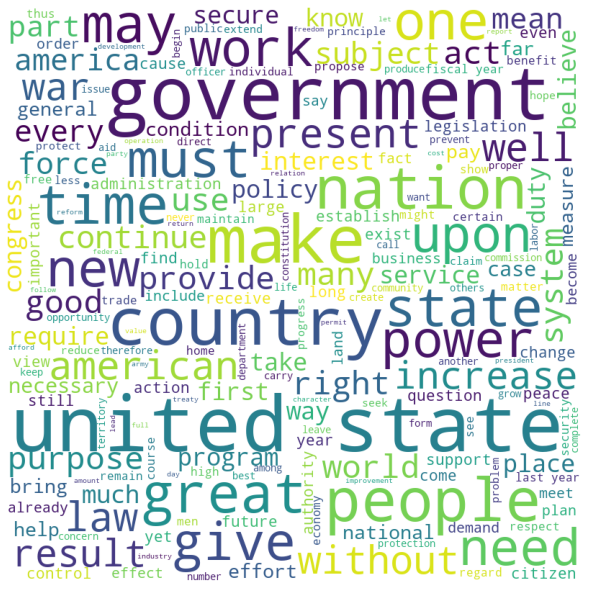

In [21]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(clean_corpuse)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Most frequent words of our corpuse

In [22]:
counter = Counter(corpuse_tokens)
most_occur = counter.most_common(50)
corpuse_fre_df = pd.DataFrame.from_records(most_occur, columns =['word', 'frequency'])
total_freq = [(x[1]/len(corpuse_tokens))*100 for x in most_occur]
corpuse_fre_df['% total frequency'] = total_freq
corpuse_fre_df

,word,frequency,% total frequency
0,state,9461,0.990919
1,government,8383,0.878013
2,year,7293,0.763849
3,make,6378,0.668014
4,congress,5843,0.611980
5,united,5039,0.527771
6,country,4770,0.499597
7,people,4581,0.479801
8,great,4478,0.469013
9,would,4255,0.445657


### Most frequent words for each president

In [23]:
president_tokenized_doc = {}

# tokenize president speaches
for president in cleaned_text_dict.keys():
    president_tokenized_doc[president] = tokenize_text(cleaned_text_dict[president])
    
# create frequents 
president_dataframe = {}
for opt in president_tokenized_doc.keys():
     president_dataframe[opt] = FreqDist(president_tokenized_doc[opt]).most_common(50)

freq_analysis_word = pd.DataFrame(president_dataframe)
freq_analysis_word

,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James K. Polk,...,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump,Joseph R. Biden
0,"(government, 364)","(state, 168)","(state, 282)","(state, 339)","(government, 315)","(year, 199)","(year, 302)","(year, 186)","(state, 123)","(state, 192)",...,"(state, 536)","(state, 177)","(government, 166)","(state, 292)","(state, 139)","(government, 283)","(state, 203)","(state, 310)","(government, 210)","(government, 95)"
1,"(make, 313)","(make, 159)","(war, 210)","(year, 271)","(state, 290)","(new, 151)","(state, 273)","(new, 166)","(year, 96)","(year, 120)",...,"(government, 501)","(government, 167)","(state, 142)","(government, 283)","(congress, 85)","(state, 240)","(make, 199)","(government, 246)","(state, 136)","(state, 81)"
2,"(state, 290)","(government, 156)","(government, 209)","(congress, 265)","(make, 258)","(must, 143)","(government, 261)","(program, 118)","(war, 87)","(american, 119)",...,"(make, 372)","(united, 113)","(year, 135)","(make, 187)","(year, 83)","(make, 198)","(year, 179)","(congress, 183)","(world, 110)","(law, 79)"
3,"(congress, 205)","(nation, 135)","(year, 188)","(government, 254)","(year, 213)","(federal, 142)","(make, 250)","(also, 115)","(make, 85)","(people, 115)",...,"(year, 308)","(year, 86)","(make, 129)","(year, 163)","(government, 82)","(year, 183)","(government, 176)","(year, 179)","(nation, 96)","(would, 75)"
4,"(great, 200)","(year, 132)","(make, 180)","(people, 206)","(congress, 196)","(state, 123)","(american, 204)","(people, 115)","(government, 82)","(make, 92)",...,"(congress, 283)","(congress, 81)","(must, 120)","(congress, 152)","(united, 71)","(country, 151)","(new, 133)","(make, 165)","(united, 92)","(nation, 70)"
5,"(country, 199)","(law, 131)","(united, 164)","(would, 202)","(united, 185)","(make, 121)","(upon, 202)","(work, 111)","(united, 80)","(would, 88)",...,"(great, 280)","(community, 81)","(congress, 113)","(united, 140)","(nation, 68)","(law, 145)","(congress, 132)","(united, 147)","(people, 84)","(upon, 65)"
6,"(year, 184)","(country, 118)","(congress, 153)","(country, 197)","(great, 154)","(program, 108)","(great, 198)","(government, 102)","(nation, 77)","(united, 85)",...,"(united, 269)","(act, 76)","(people, 107)","(would, 136)","(great, 67)","(would, 143)","(people, 125)","(country, 140)","(upon, 84)","(people, 64)"
7,"(american, 181)","(great, 118)","(would, 148)","(make, 194)","(american, 147)","(also, 102)","(country, 195)","(american, 101)","(upon, 70)","(country, 82)",...,"(people, 256)","(make, 71)","(nation, 100)","(may, 113)","(people, 62)","(upon, 140)","(public, 120)","(public, 134)","(free, 84)","(men, 63)"
8,"(law, 177)","(people, 111)","(may, 144)","(american, 191)","(would, 147)","(government, 101)","(congress, 184)","(congress, 96)","(right, 70)","(congress, 80)",...,"(country, 254)","(war, 68)","(country, 93)","(new, 113)","(make, 60)","(may, 134)","(country, 118)","(upon, 134)","(great, 81)","(great, 61)"
9,"(would, 169)","(congress, 111)","(great, 143)","(great, 190)","(new, 143)","(need, 95)","(work, 181)","(state, 87)","(congress, 67)","(one, 78)",...,"(law, 252)","(upon, 59)","(great, 86)","(people, 112)","(upon, 54)","(united, 132)","(great, 117)","(people, 118)","(make, 81)","(one, 56)"


### Statistical information

In [24]:
def Statistical_info(text_tokens):
  print (f"Number of words : {len(text_tokens)}")
  print (f"Number of unique  words : {len(set(text_tokens))}")
  word_len_avg = sum(map(len, text_tokens))/float(len(text_tokens))
  print (f"Average word length : {word_len_avg}")
  sent_len_avg = np.mean([len(' '.join(s)) for s in text_tokens])
  max_w = max(text_tokens, key=len)
  min_w = min(text_tokens, key=len)
  print (f"Longest word : {max_w}")
  print (f"Shortest word : {min_w}")

### Statistical information of corpuse

In [25]:
  print('*' *50)
  print('Statical information of corpus')
  print('*' *50)
  Statistical_info(corpuse_tokens)

**************************************************
Statical information of corpus
**************************************************
Number of words : 954770
Number of unique  words : 20951
Average word length : 6.673529750620569
Longest word : weapons-of-mass-destruction-related
Shortest word : two


###Statistical information for each president

In [26]:
for president, tokens_list in tokenized_text_dict.items():
  print('*' *50)
  print(president)
  print('*' *50)
  Statistical_info(tokens_list)


**************************************************
George Washington
**************************************************
Number of words : 36984
Number of unique  words : 4970
Average word length : 6.875567813108371
Longest word : politico-geographical
Shortest word : two
**************************************************
John Adams
**************************************************
Number of words : 21230
Number of unique  words : 4124
Average word length : 6.569241639189825
Longest word : most-favored-nation
Shortest word : ebb
**************************************************
Thomas Jefferson
**************************************************
Number of words : 26466
Number of unique  words : 4539
Average word length : 6.536764150230485
Longest word : provost-marshal-general
Shortest word : war
**************************************************
James Madison
**************************************************
Number of words : 33029
Number of unique  words : 5083
Average word length :

### Extract Posetive and Negative words of each president's speech

In [27]:
def extract_pos_neg(textTokens):
  sid = SentimentIntensityAnalyzer()
  pos_word_list=[]
  neg_word_list=[]

  for word in textTokens:
      if (sid.polarity_scores(word)['compound']) >= 0.5:
          pos_word_list.append(word)
      elif (sid.polarity_scores(word)['compound']) <= -0.5:
          neg_word_list.append(word)
  return pos_word_list, neg_word_list

In [28]:
for president, tokens_list in tokenized_text_dict.items():
  print('*' *250)
  print(president)
  print('*' *250)
  pos, neg= extract_pos_neg(president_tokens)
  print('Positive Words:',list(set(pos)))        
  print('Negative Words :',list(set(neg)))    

**********************************************************************************************************************************************************************************************************************************************************
George Washington
**********************************************************************************************************************************************************************************************************************************************************
Positive Words: ['appreciative', 'kind', 'strong', 'honorable', 'gain', 'award', 'inspire', 'glorious', 'gratitude', 'honorably', 'inspiration', 'excellence', 'peace', 'beautiful', 'peacefully', 'loyalty', 'perfection', 'admirable', 'praise', 'encourage', 'fantastic', 'great', 'generous', 'freedom', 'love', 'happy', 'admiration', 'happiness', 'excellent', 'admirably', 'best', 'courteous', 'splendid', 'free', 'reward', 'appreciated', 'ideal', 'rich', 'liberty', 'wisdom', 'just

### Clustering presidents with all speeches of them

- use TF-IDF to convert text to vector of numbers

In [29]:
all_p_text = list(cleaned_text_dict.values())
vectorizer = TfidfVectorizer(tokenizer=tokenize_text)
X = vectorizer.fit_transform(all_p_text)
vectorizer.get_feature_names_out()
print(X.shape)

(43, 20789)


### Convert word's vectors to the data frame

In [30]:
count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
count_vect_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a.d,a.m.e,aana,aaron,abandon,abandoned,abandoning,abandonment,abate,abatement,...,zimbabwe-can,zimbabwean,zinc,zion,zollverein,zone,zoological,zoom,zuloaga,ôtil
0,0.000000,0.000000,0.000000,0.000000,0.002436,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012267,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.001399,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002114,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.013111,0.003313,0.000000,0.001794,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003302,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.006979,0.000000,0.000000,0.001432,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002636,0.000000,0.000000,0.011477,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.007809,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001475,0.006421,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.004846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004453,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.005413,0.001646,0.000000,0.000000,0.002702,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007460,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.006051,0.000000,0.000000,0.001657,0.000000,0.000000,0.000000,0.000000,0.004426,...,0.000000,0.000000,0.000000,0.006051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007465,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.001869,0.000000,0.000000,0.000000,0.004140,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Using k-means for clustering

In [31]:
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(X)

### Create a data frame with presidents and their cluster's label

In [32]:
p_names = list(president_text_dict.keys())
vect_df = pd.DataFrame(p_names, columns = ['President'])
vect_df['Label'] = y
vect_df

,President,Label
0,George Washington,0
1,John Adams,0
2,Thomas Jefferson,0
3,James Madison,0
4,James Monroe,0
5,John Quincy Adams,2
6,Andrew Jackson,2
7,Martin van Buren,2
8,John Tyler,0
9,James K. Polk,0


### Concatenation of word vectors and previous data frame

In [33]:
final_df = pd.concat([vect_df, count_vect_df], axis=1)
f = final_df.iloc[0:12,:]
f

,President,Label,a.d,a.m.e,aana,aaron,abandon,abandoned,abandoning,abandonment,...,zimbabwe-can,zimbabwean,zinc,zion,zollverein,zone,zoological,zoom,zuloaga,ôtil
0,George Washington,0,0.0,0.000000,0.0,0.000000,0.002436,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.012267,0.000000,0.0,0.000000,0.0
1,John Adams,0,0.0,0.000000,0.0,0.000000,0.001399,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.002114,0.000000,0.0,0.000000,0.0
2,Thomas Jefferson,0,0.0,0.000000,0.0,0.000000,0.013111,0.003313,0.0,0.001794,...,0.0,0.0,0.0,0.000000,0.0,0.003302,0.000000,0.0,0.000000,0.0
3,James Madison,0,0.0,0.000000,0.0,0.000000,0.006979,0.000000,0.0,0.001432,...,0.0,0.0,0.0,0.000000,0.0,0.002636,0.000000,0.0,0.011477,0.0
4,James Monroe,0,0.0,0.000000,0.0,0.000000,0.007809,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.001475,0.006421,0.0,0.000000,0.0
5,John Quincy Adams,2,0.0,0.000000,0.0,0.004846,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.004453,0.000000,0.0,0.000000,0.0
6,Andrew Jackson,2,0.0,0.000000,0.0,0.005413,0.001646,0.000000,0.0,0.002702,...,0.0,0.0,0.0,0.000000,0.0,0.007460,0.000000,0.0,0.000000,0.0
7,Martin van Buren,2,0.0,0.006051,0.0,0.000000,0.001657,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.006051,0.0,0.000000,0.000000,0.0,0.000000,0.0
8,John Tyler,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.007465,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
9,James K. Polk,0,0.0,0.000000,0.0,0.000000,0.001869,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


### Use PCA for dimension reduction

In [34]:
pca_num_components = 2
reduced_data = PCA(n_components=pca_num_components).fit_transform(X.todense())
dense_df = pd.DataFrame(reduced_data, columns=['X','Y'])
dense_df


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


,X,Y
0,-0.116360,-0.069356
1,-0.056397,0.101886
2,-0.091113,0.016614
3,-0.081168,0.069815
4,-0.090534,-0.022669
5,0.442655,-0.118503
6,0.044065,0.059733
7,0.385767,-0.016425
8,-0.107780,0.083569
9,0.017430,0.204604


### Concatenation of dense data frame and president' label

In [35]:
final_dense_df = pd.concat([vect_df, dense_df], axis=1)
final_dense_df

,President,Label,X,Y
0,George Washington,0,-0.116360,-0.069356
1,John Adams,0,-0.056397,0.101886
2,Thomas Jefferson,0,-0.091113,0.016614
3,James Madison,0,-0.081168,0.069815
4,James Monroe,0,-0.090534,-0.022669
5,John Quincy Adams,2,0.442655,-0.118503
6,Andrew Jackson,2,0.044065,0.059733
7,Martin van Buren,2,0.385767,-0.016425
8,John Tyler,0,-0.107780,0.083569
9,James K. Polk,0,0.017430,0.204604


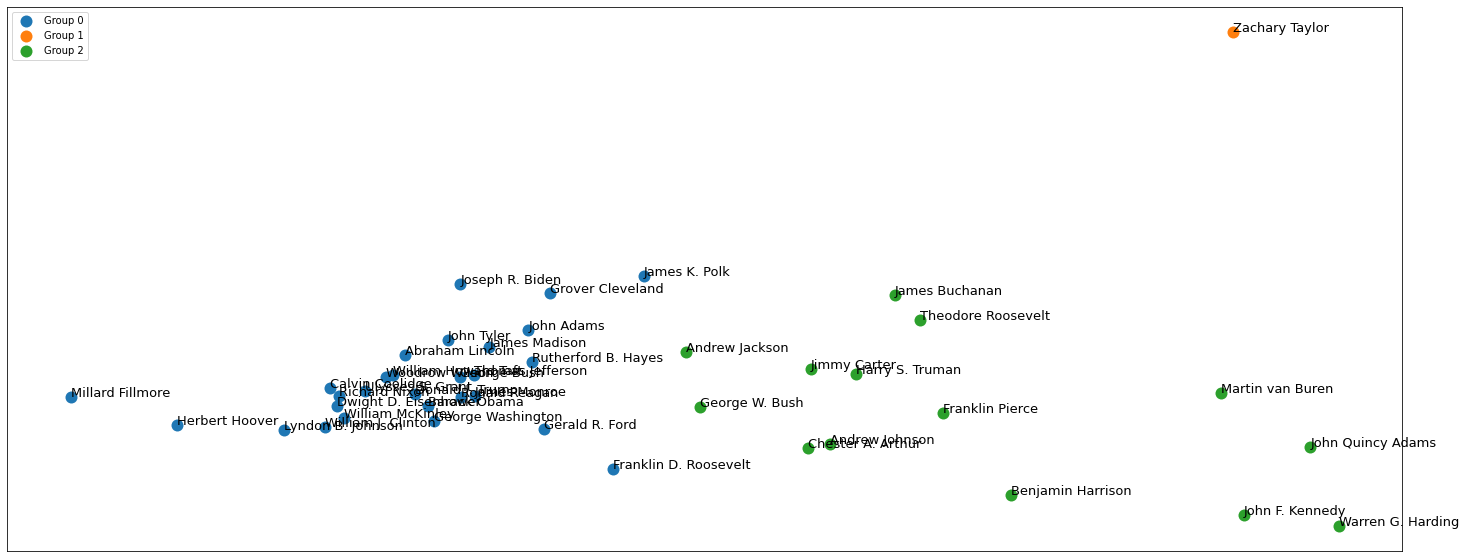

In [36]:
groups = final_dense_df.groupby('Label')
cluster_names_0 = {0: 'Group 0', 1: 'Group 1', 2: 'Group 2' }
fig, ax = plt.subplots(figsize=(25, 10)) 
for name, group in groups:
    ax.plot(group.X, group.Y, marker='o', linestyle='', ms=12, 
            label=cluster_names_0[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')
#add label in x,y position with the label as the speech title
for i in range(len(final_dense_df)):
    ax.text(final_dense_df.loc[i]['X'], final_dense_df.loc[i]['Y'], final_dense_df.loc[i]['President'], size=13)  

plt.show()

## Clustering each speech of president
- repeat pervious steps

In [37]:
clean_all_text = [normalize_and_cleaning(t) for t in all_text_list]

In [38]:
vectorizer2 = TfidfVectorizer(stop_words='english',max_df = 0.42, min_df = 0.01)
Y = vectorizer2.fit_transform(clean_all_text)
print(Y.shape)
count_vect_df2 = pd.DataFrame(Y.todense(), columns=vectorizer2.get_feature_names())
count_vect_df2


(239, 9294)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandoned,abandonment,abate,abatement,abdicate,abdication,abet,abeyance,abhorrence,abide,...,zarqawi,zeal,zealand,zealous,zealously,zelaya,zero,zimbabwe,zinc,zone
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.017302,0.020878,0.096665,0.0,0.0,0.0,0.027486
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.023700,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.029925,0.0,0.0,0.0,0.0,0.018149,...,0.0,0.000000,0.023176,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017440
235,0.0,0.0,0.017689,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
236,0.0,0.0,0.017002,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
237,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.017887,0.056160,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [39]:
kmeans = KMeans(n_clusters=2)
y2 = kmeans.fit_predict(Y)
p_names2 = concat_president_year
vect_df2 = pd.DataFrame(p_names2, columns = ['President'])
vect_df2['Label'] = y2

In [40]:
pca_num_components = 2
reduced_data2 = PCA(n_components=pca_num_components).fit_transform(Y.todense())
dense_df2 = pd.DataFrame(reduced_data2, columns=['X2','Y2'])
dense_df2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


,X2,Y2
0,-0.183168,0.277013
1,-0.051321,0.177678
2,0.154233,0.213893
3,-0.092063,0.301310
4,-0.087243,0.272315
...,...,...
234,0.459480,-0.142664
235,-0.226470,0.045463
236,0.187306,0.107861
237,-0.244074,-0.133160


In [41]:
final_dense_df2 = pd.concat([vect_df2, dense_df2], axis=1)
final_dense_df2

,President,Label,X2,Y2
0,George Washington_1790,1,-0.183168,0.277013
1,George Washington_1790,1,-0.051321,0.177678
2,George Washington_1791,0,0.154233,0.213893
3,George Washington_1792,1,-0.092063,0.301310
4,George Washington_1793,1,-0.087243,0.272315
...,...,...,...,...
234,Barack Obama_2016,0,0.459480,-0.142664
235,Donald J. Trump_2018,1,-0.226470,0.045463
236,Donald J. Trump_2019,0,0.187306,0.107861
237,Donald J. Trump_2020,1,-0.244074,-0.133160


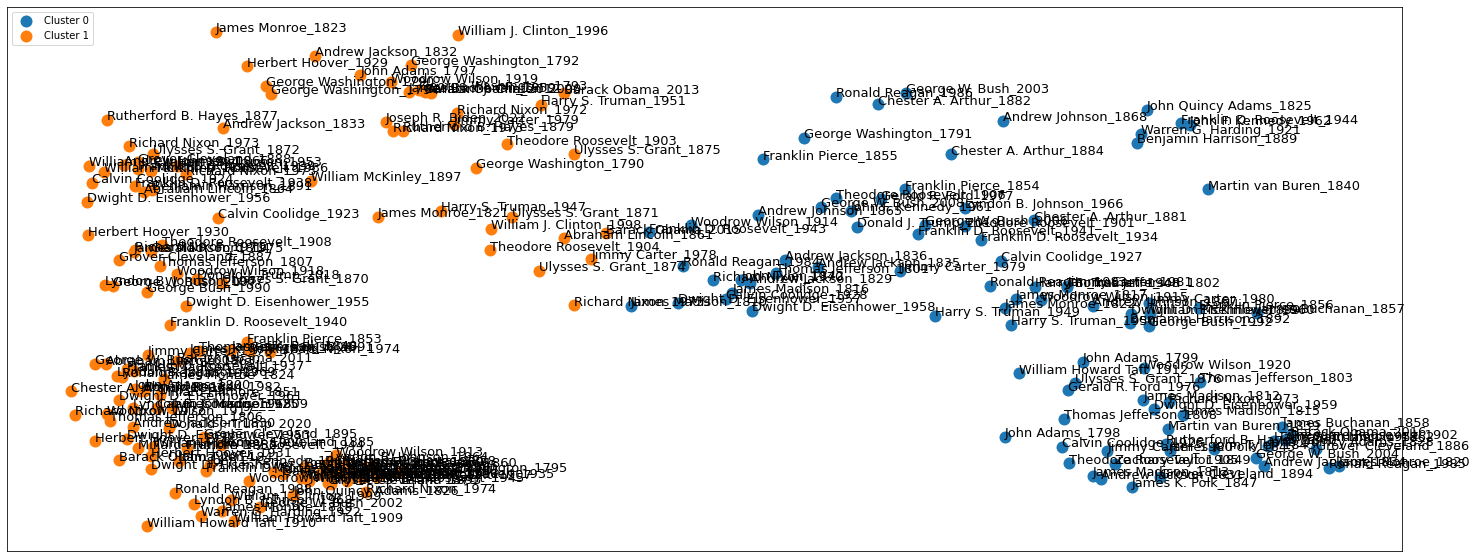

In [42]:
groups2 = final_dense_df2.groupby('Label')
cluster_names_0 = {0: 'Cluster 0', 1: 'Cluster 1' }
# set up plot
fig, ax = plt.subplots(figsize=(25, 10))
for name, group in groups2:
    ax.plot(group.X2, group.Y2, marker='o', linestyle='', ms=12, 
            label=cluster_names_0[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left') 

for i in range(len(final_dense_df2)):
    ax.text(final_dense_df2.loc[i]['X2'], final_dense_df2.loc[i]['Y2'], final_dense_df2.loc[i]['President'], size=13)  

    
    
plt.show()

## Using NMF model

In [43]:
vectorizer = TfidfVectorizer(stop_words='english',tokenizer=tokenize_text, max_df = 0.42, min_df = 0.01) 
doc_word = vectorizer.fit_transform(clean_all_text) 
doc_word.shape

(239, 9508)

In [44]:
n_topics = 8 # number of topics
nmf_model = NMF(n_topics) # create an object
doc_topic = nmf_model.fit_transform(doc_word)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [45]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), #,"component_9","component_10","component_11","component_12"
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = vectorizer.get_feature_names()) #8 components in final draft
topic_word

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandoned,abandonment,abate,abatement,abdicate,abdication,abet,abeyance,abhorrence,abide,...,zarqawi,zeal,zealand,zealous,zealously,zelaya,zero,zimbabwe,zinc,zone
component_1,0.009,0.018,0.007,0.008,0.000,0.000,0.003,0.016,0.003,0.005,...,0.000,0.032,0.008,0.010,0.009,0.006,0.004,0.000,0.002,0.016
component_2,0.004,0.002,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.007,...,0.000,0.000,0.000,0.000,0.000,0.000,0.022,0.000,0.000,0.031
component_3,0.000,0.002,0.000,0.007,0.000,0.003,0.005,0.000,0.000,0.015,...,0.000,0.054,0.000,0.032,0.006,0.000,0.000,0.000,0.000,0.000
component_4,0.001,0.002,0.003,0.007,0.000,0.005,0.000,0.000,0.000,0.000,...,0.000,0.001,0.003,0.000,0.000,0.000,0.006,0.006,0.000,0.009
component_5,0.000,0.011,0.005,0.000,0.007,0.002,0.000,0.002,0.000,0.012,...,0.000,0.002,0.004,0.003,0.002,0.016,0.000,0.000,0.003,0.026
component_6,0.000,0.000,0.001,0.000,0.003,0.005,0.000,0.000,0.000,0.013,...,0.000,0.003,0.014,0.000,0.000,0.000,0.000,0.000,0.005,0.000
component_7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.026,0.000,0.000,0.000,0.000,0.000,0.005,0.015,0.000,0.001
component_8,0.000,0.012,0.003,0.002,0.000,0.001,0.001,0.001,0.004,0.009,...,0.000,0.015,0.004,0.000,0.005,0.000,0.000,0.000,0.000,0.000


In [46]:
def nmf_display(nmf_model, tf_vectorizer_model,number_show):
    names = tf_vectorizer_model.get_feature_names()
    #number_show = 10
    for ind, topic in enumerate(nmf_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")
        

In [47]:
n_top_words = 10
feature_names = vectorizer.get_feature_names()
nmf_display(nmf_model, vectorizer, n_top_words)

Topic 0: ['silver', 'gold', 'cent', 'pension', 'circulation', 'currency', 'coinage', 'note', 'coin', 'postal']
Topic 1: ['tonight', 'job', 'thank', 'parent', 'challenge', 'percent', 'deficit', 'college', 'hard', 'kid']
Topic 2: ['spain', 'militia', 'tribe', 'navigation', 'gentleman', 'colony', 'french', 'legislature', 'neutral', 'ensue']
Topic 3: ['billion', 'major', 'goal', 'percent', 'inflation', 'nuclear', 'soviet', 'oil', 'housing', 'environmental']
Topic 4: ['corporation', 'interstate', 'tariff', 'conference', 'cent', 'railroad', 'philippine', 'canal', 'bureau', 'forest']
Topic 5: ['communist', 'soviet', 'objective', 'democratic', 'atomic', 'aggression', 'democracy', 'group', 'living', 'weapon']
Topic 6: ['iraq', 'terrorist', 'iraqi', 'terror', 'tonight', 'qaida', 'regime', 'afghanistan', 'saddam', 'weapon']
Topic 7: ['texas', 'mexican', 'slave', 'california', 'currency', 'paper', 'slavery', 'oregon', 'specie', 'note']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:

H = pd.DataFrame(doc_topic.round(5),   index= concat_president_year, #,"component_9","component_10"          
             columns = ["component_1","component_2", "component_3","component_4","component_5","component_6","component_7","component_8"])


In [49]:
H1 = H.reset_index(drop=True)

In [50]:
model = KMeans(n_clusters = 8)
model.fit(H1)
print (model.labels_)
H1['clust'] = pd.Series(model.labels_)
H1['Year'] = df['Year']
H1.head()

[5 5 4 5 5 5 3 3 5 7 6 2 4 0 6 2 3 2 1 6 2 4 2 6 6 1 6 4 0 3 3 6 5 4 5 2 0
 3 3 6 4 2 6 5 1 6 0 4 3 3 6 0 3 4 6 2 6 2 6 2 7 3 2 2 2 4 4 0 0 6 5 3 5 6
 2 1 4 1 0 4 3 1 5 1 3 5 5 6 1 3 5 7 4 4 2 4 2 6 1 1 0 3 1 0 3 7 3 3 5 1 0
 3 4 6 5 5 7 4 3 1 3 3 3 6 3 4 0 3 2 1 5 6 0 3 1 1 2 7 0 4 5 1 3 3 4 3 1 2
 1 1 2 4 3 4 0 2 3 5 0 0 0 5 6 1 3 3 1 1 1 4 6 0 2 4 0 3 3 2 0 1 3 2 4 1 5
 2 1 5 4 1 3 6 2 3 1 4 0 4 2 5 4 7 0 0 2 4 4 6 4 2 3 1 1 6 1 3 5 3 5 3 5 3
 4 6 2 4 1 4 3 2 5 5 2 4 6 1 4 2 5]


,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,clust,Year
0,0.09603,0.0,0.00865,0.00000,0.28086,0.00000,0.0,0.00000,5,1790
1,0.00000,0.0,0.00000,0.01220,0.24050,0.03494,0.0,0.02661,5,1790
2,0.00000,0.0,0.00813,0.10741,0.09330,0.28081,0.0,0.00000,4,1791
3,0.00000,0.0,0.00620,0.00831,0.37958,0.01155,0.0,0.00000,5,1792
4,0.00000,0.0,0.01849,0.02461,0.35937,0.00770,0.0,0.00370,5,1793


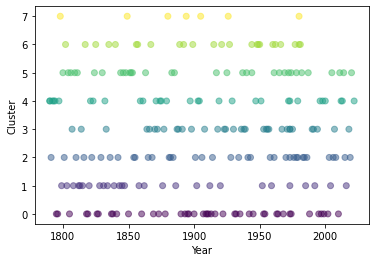

In [72]:
plt.scatter(H1['Year'], H1['clust'], c= model.labels_.astype(float), s=50, alpha=0.5)

plt.xlabel("Year") 
plt.ylabel("Cluster")
plt.show()

### Named Entity Recognition (NER)

In [52]:
def specify_NER(raw_text):
  ents = Counter()
  doc = ner.name(raw_text, language='en_core_web_sm')
  text_label = [(X.text, X.label_) for X in doc]
  for text, label in text_label:
      raw_text = raw_text.replace(text, label)
      ents[f"{label}"] += 1   
  return raw_text, ents

### Plot number of occurrences of each entity

In [53]:
def create_bar_plot(ents, president):
  ents_names, ents_count = zip(*ents.items())
  fig = plt.figure(figsize = (25,4))
  plt.bar(ents_names, ents_count, color ='#5F9EA0')
  plt.ylabel("No. Of Each Entity")
  plt.title(president,fontsize=25)
  plt.show()

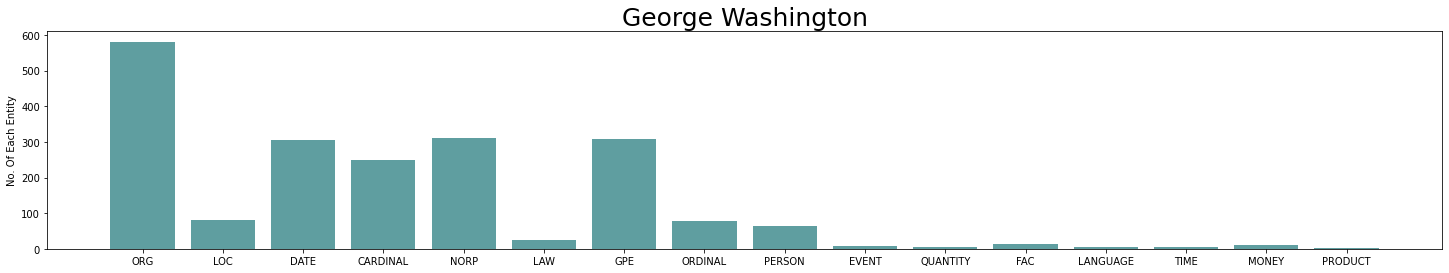

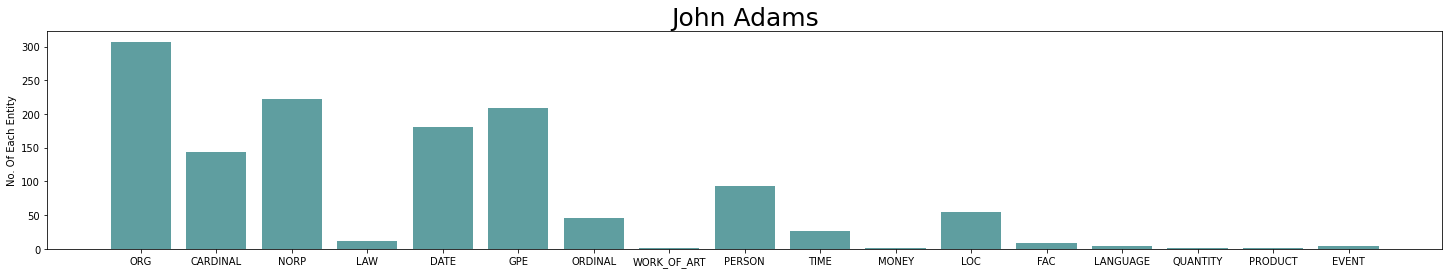

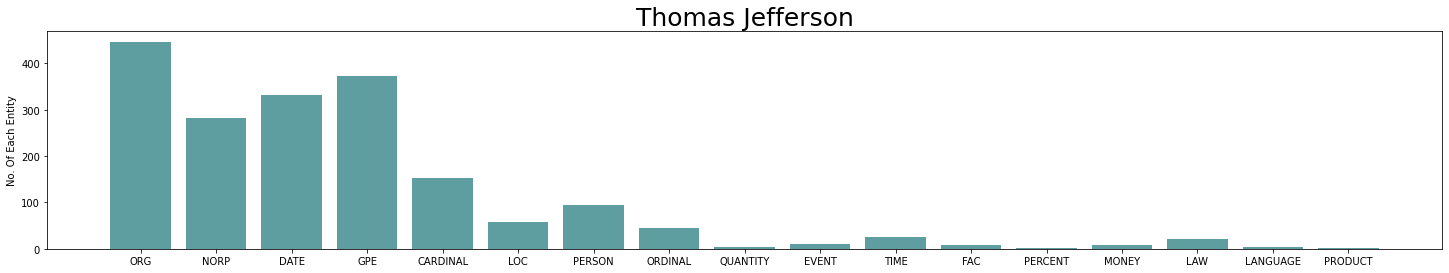

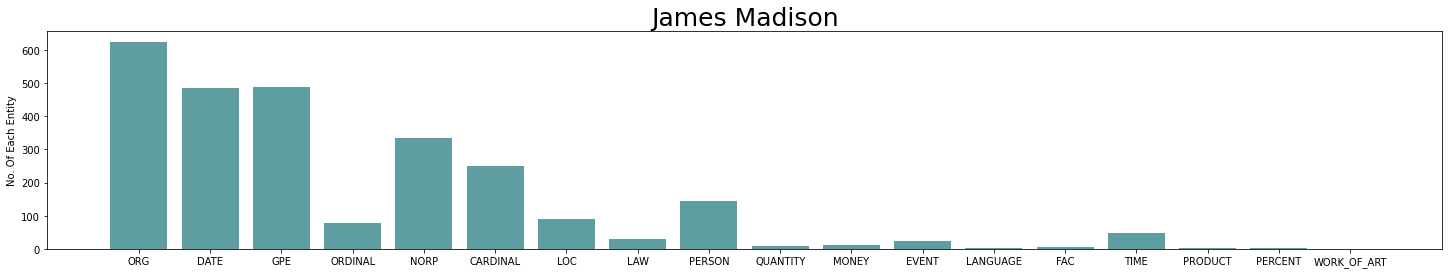

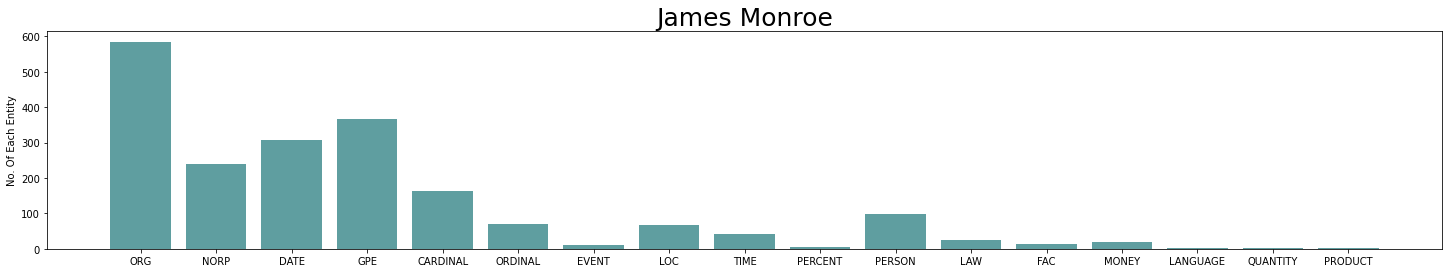

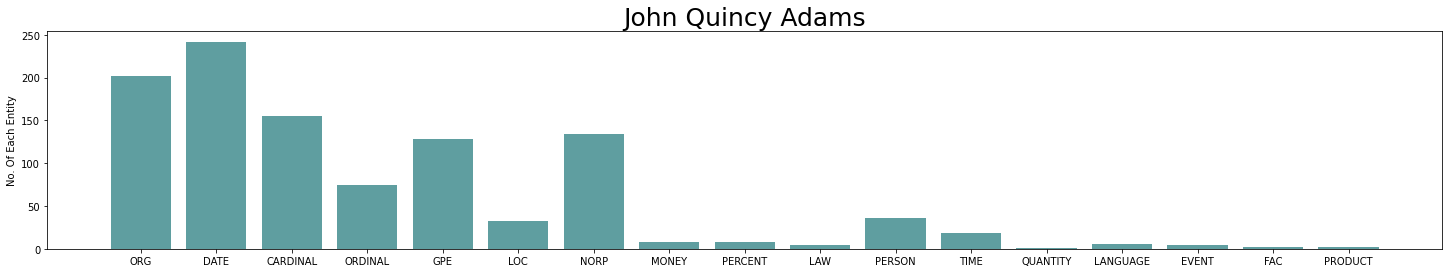

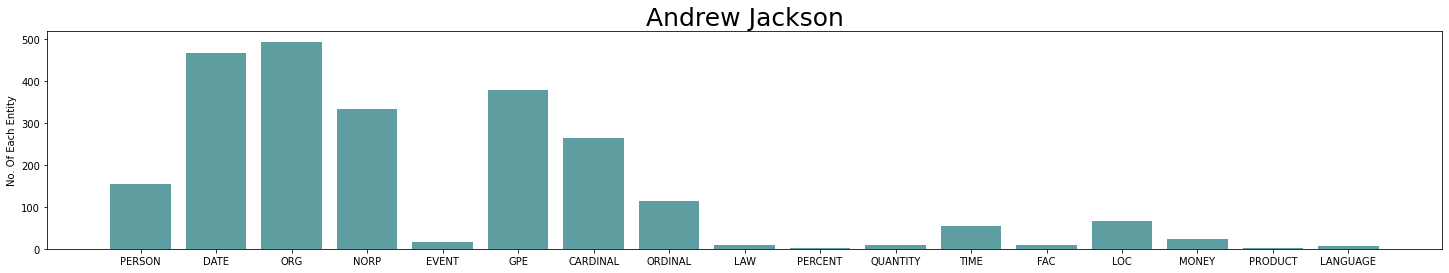

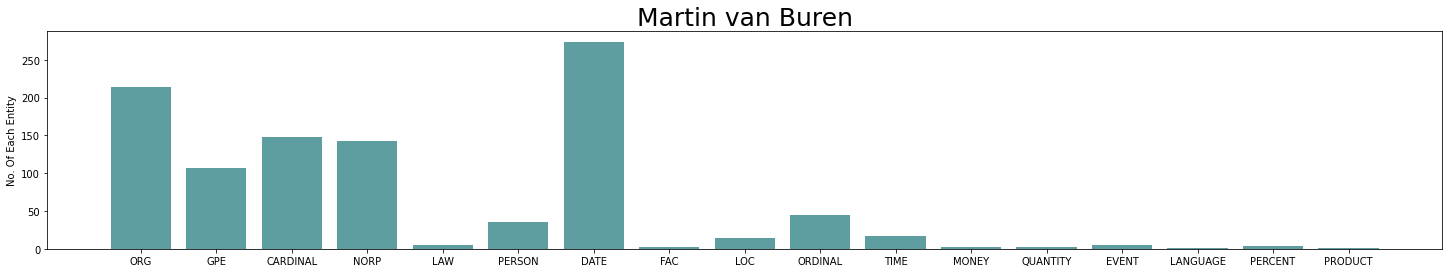

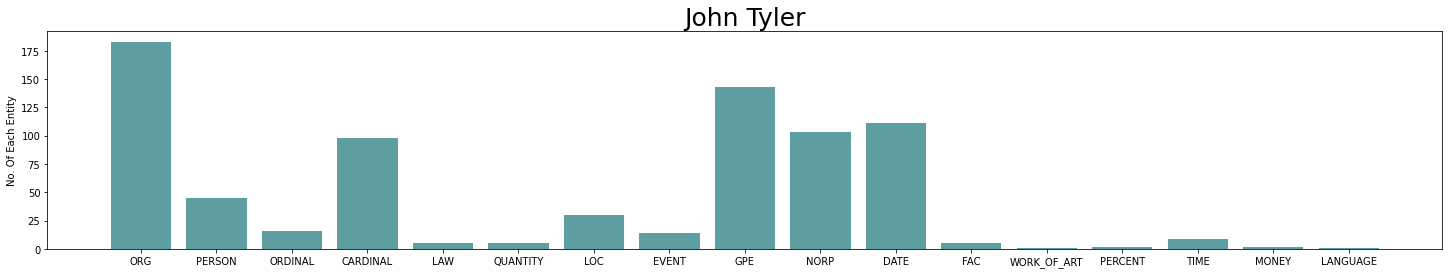

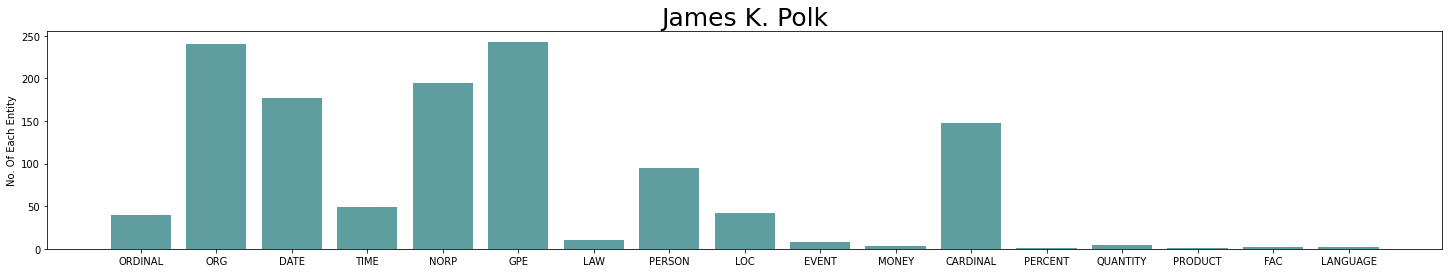

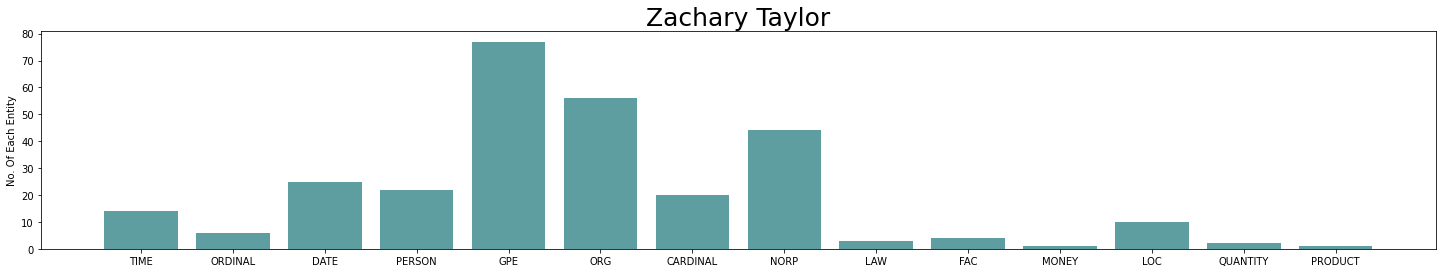

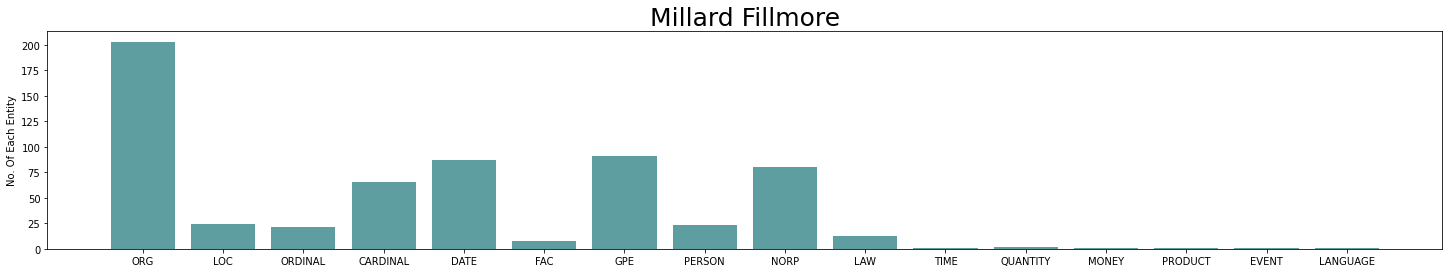

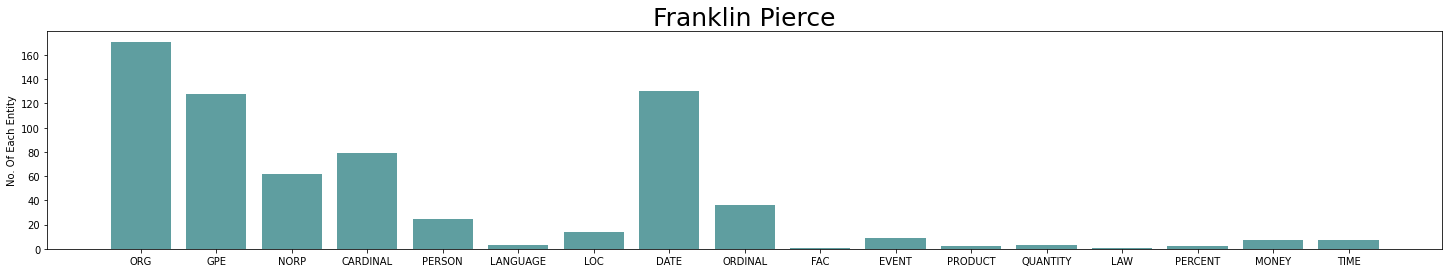

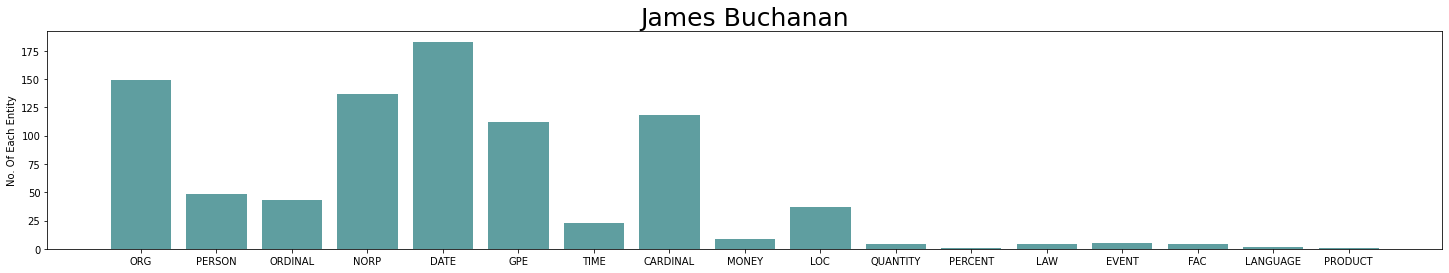

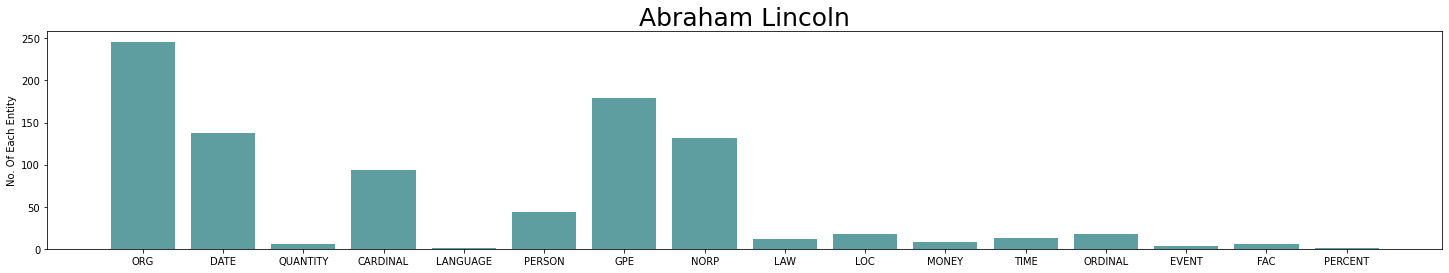

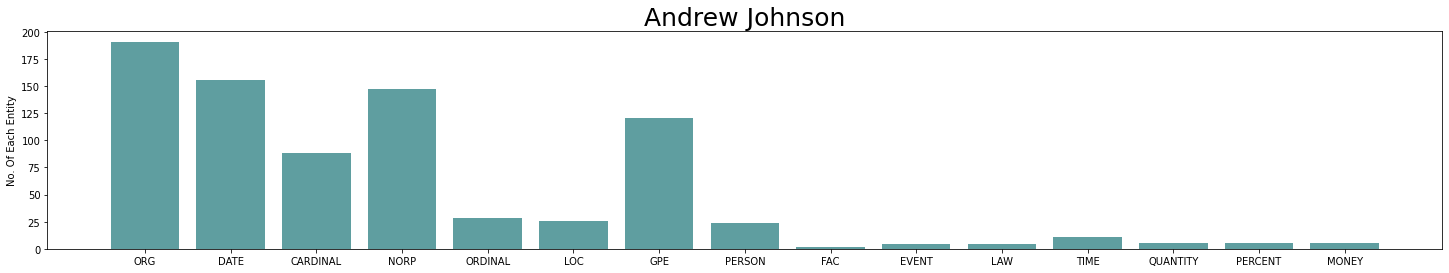

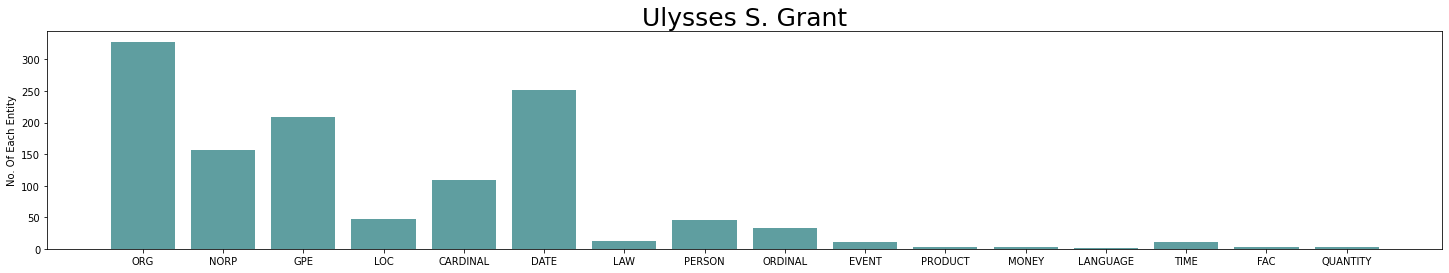

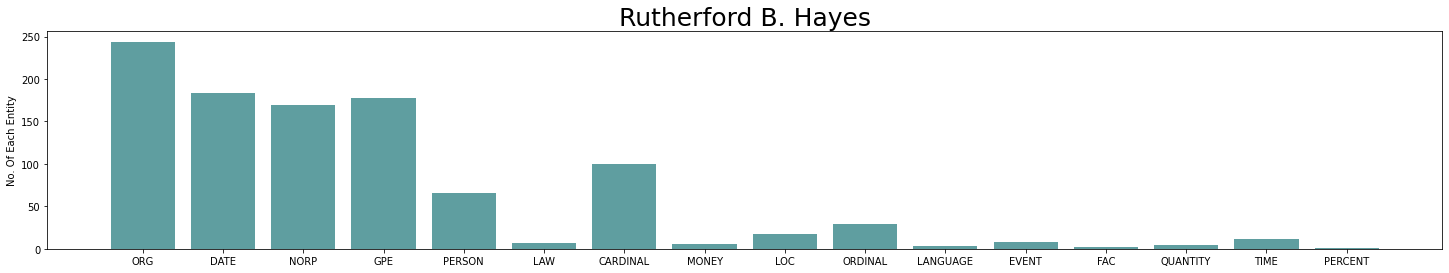

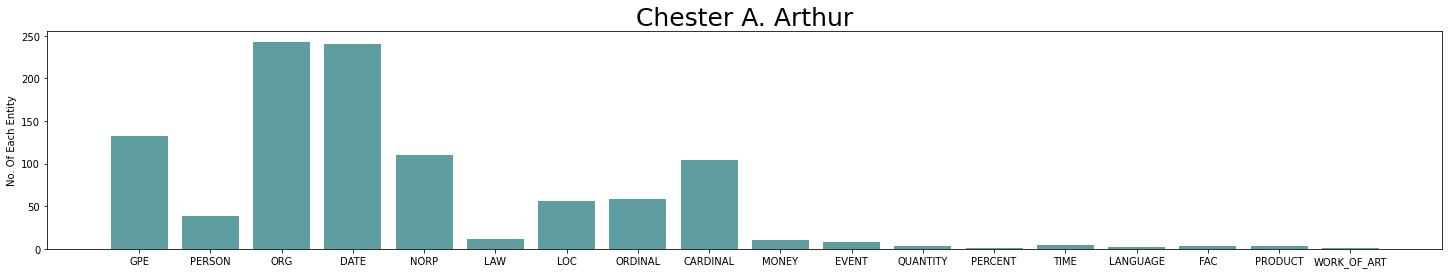

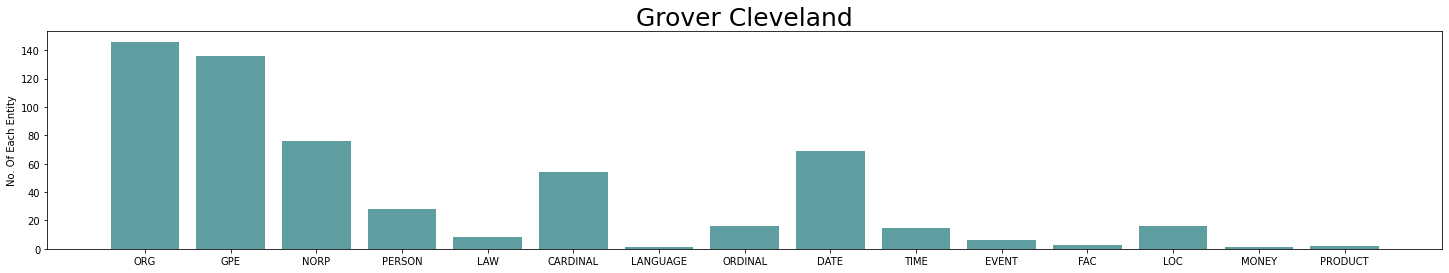

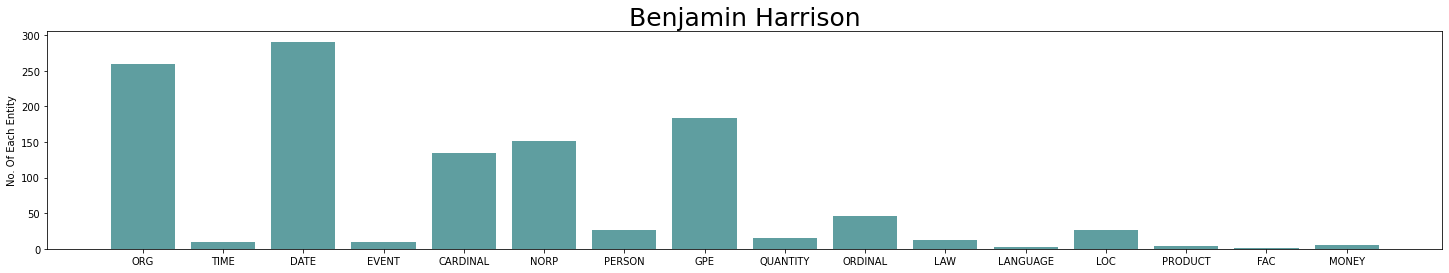

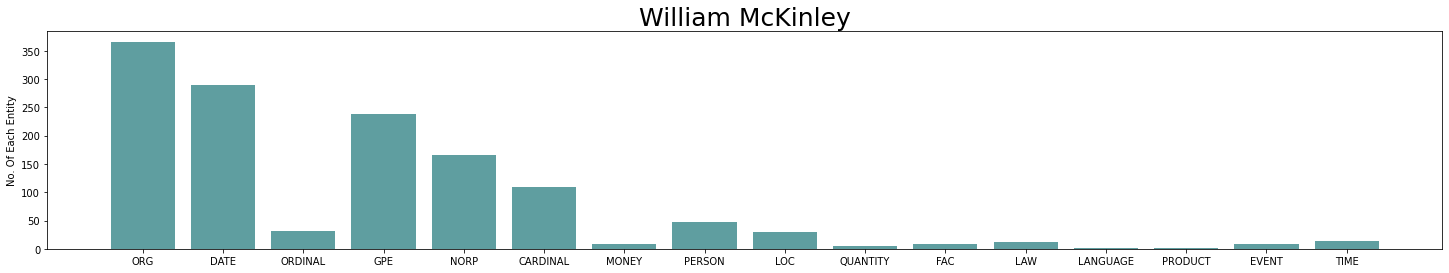

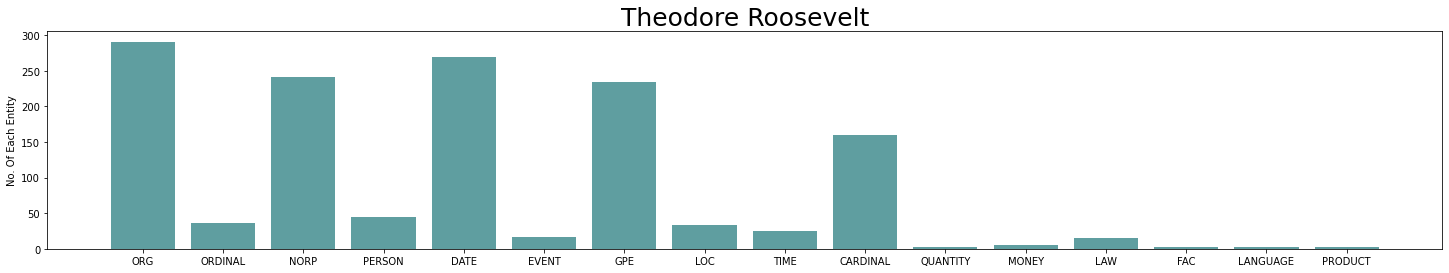

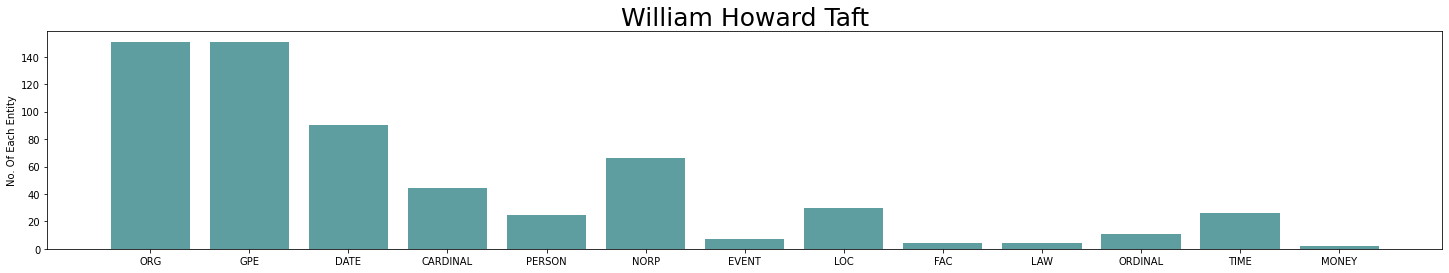

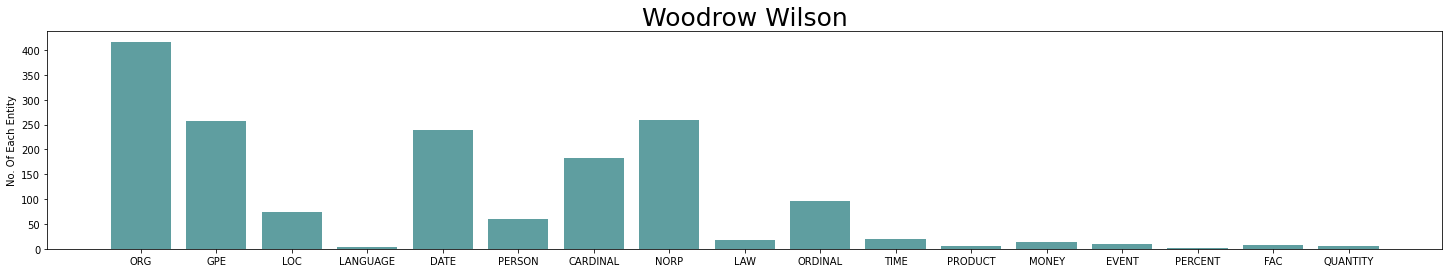

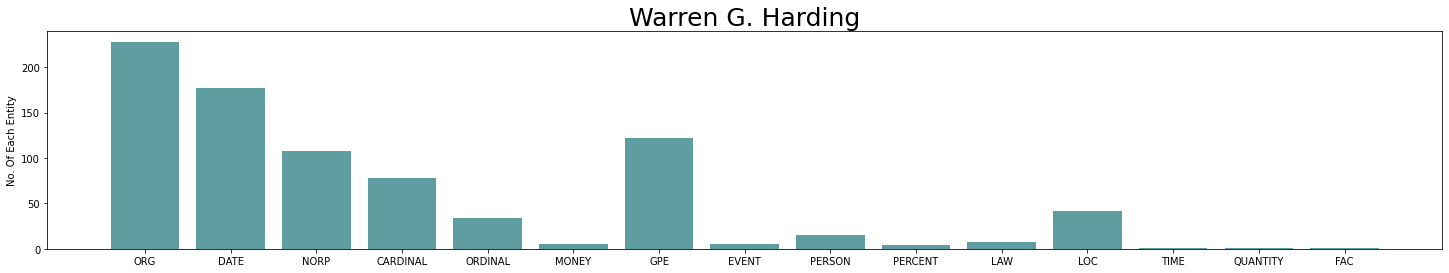

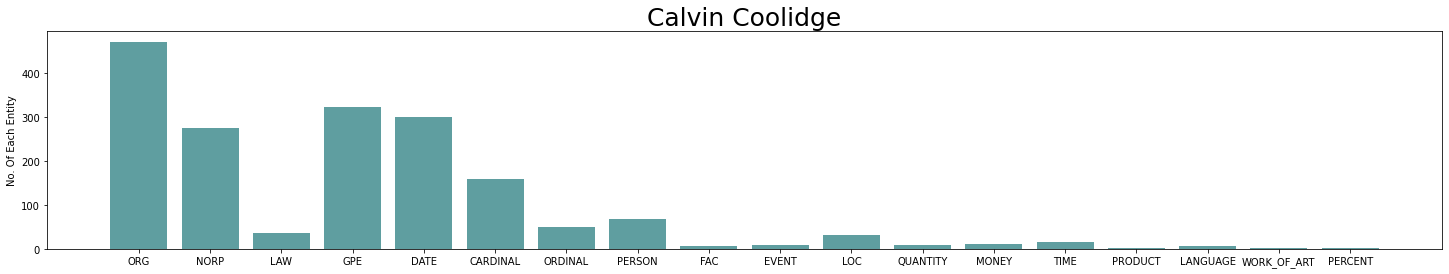

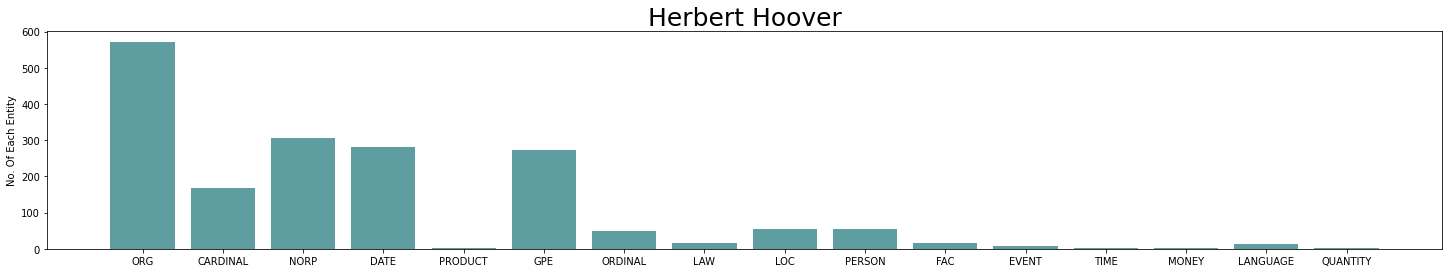

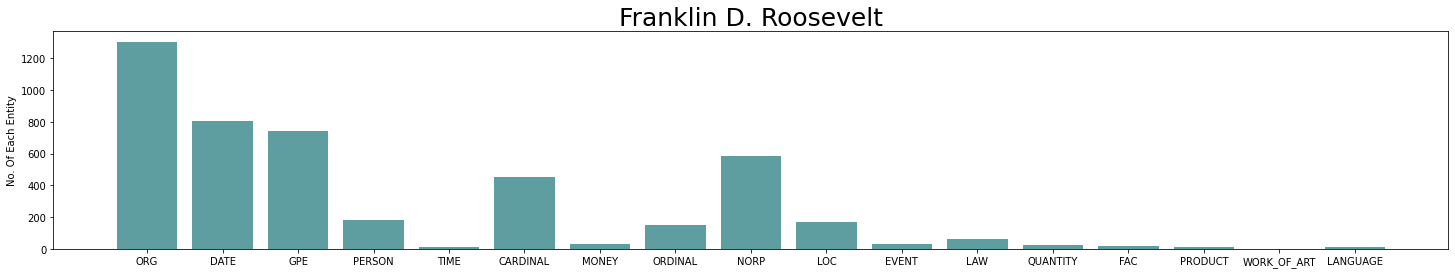

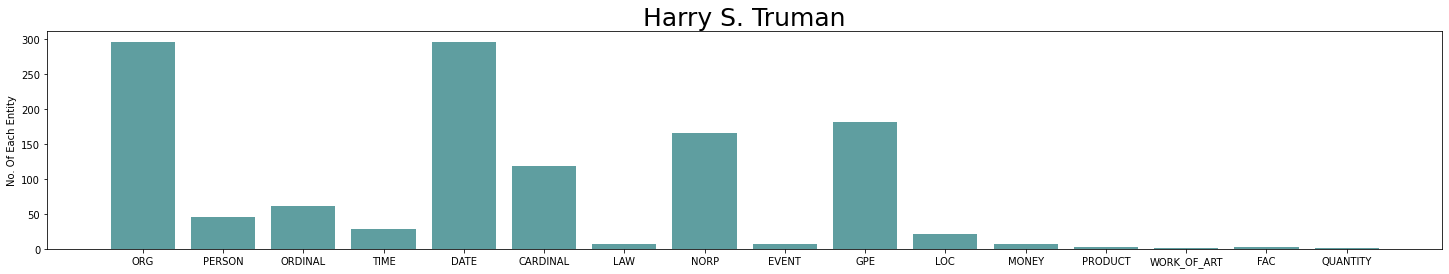

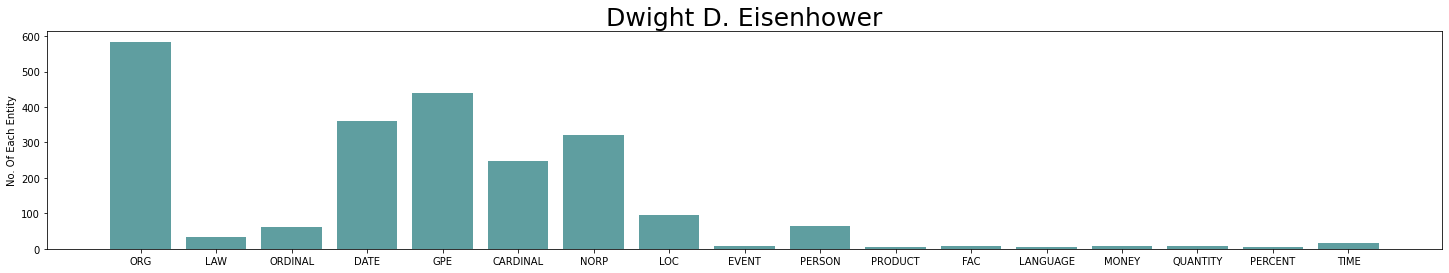

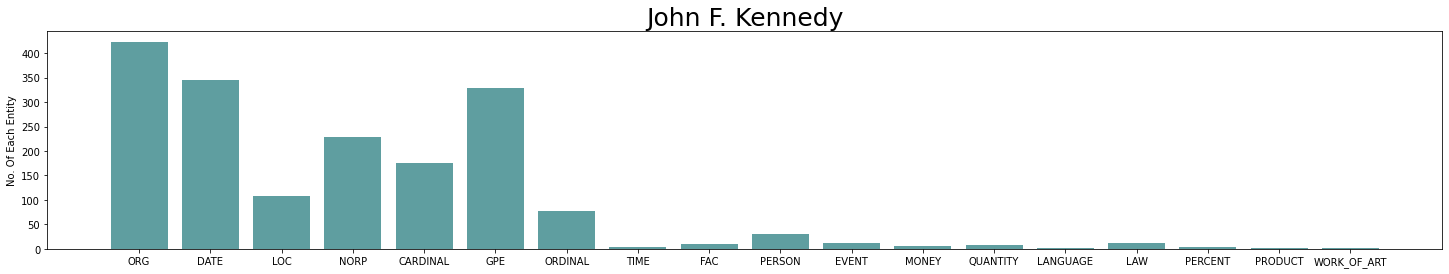

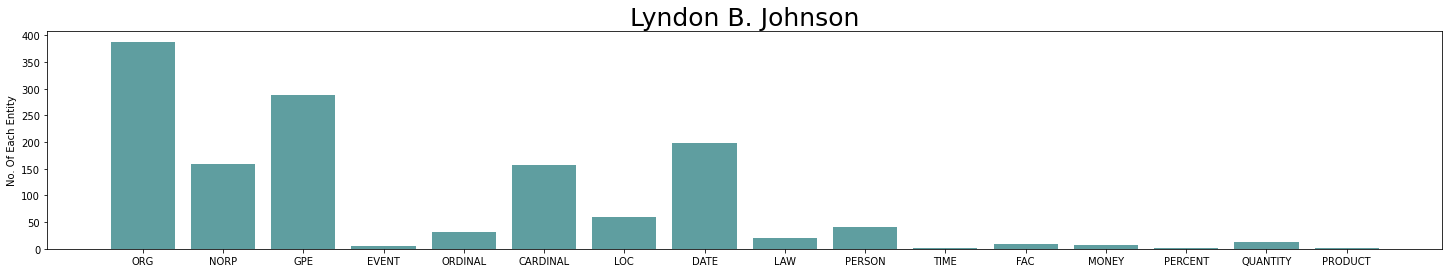

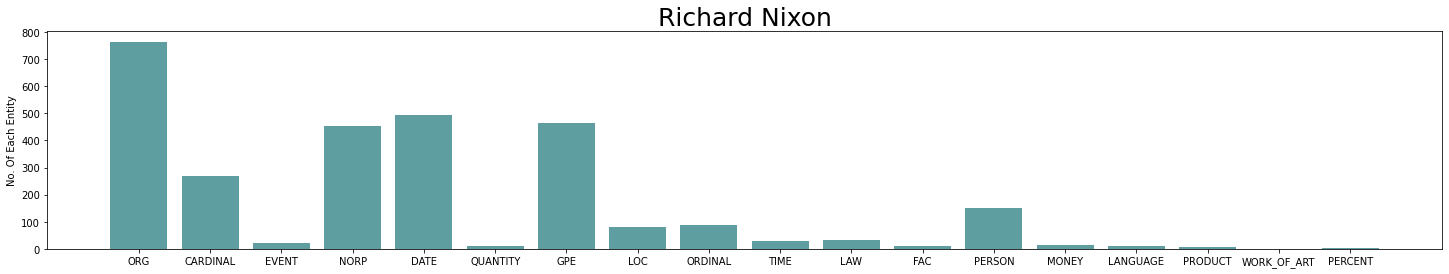

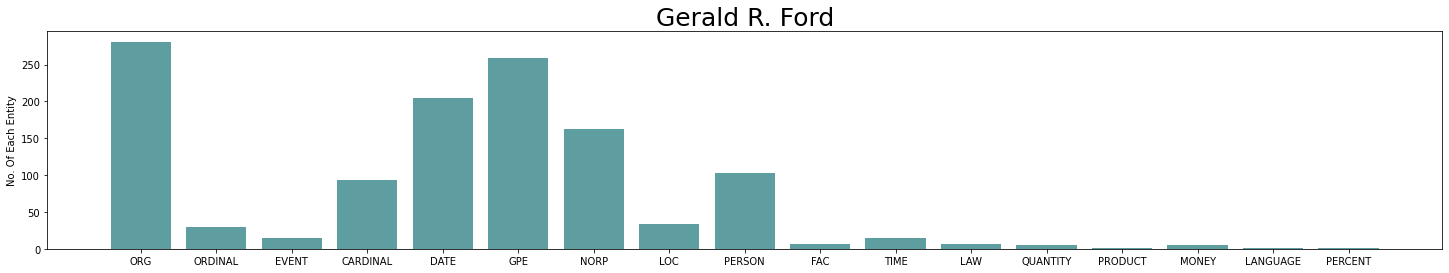

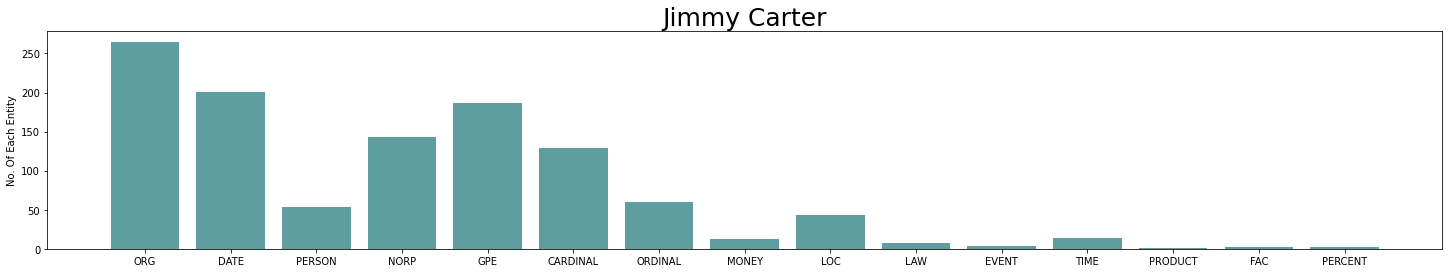

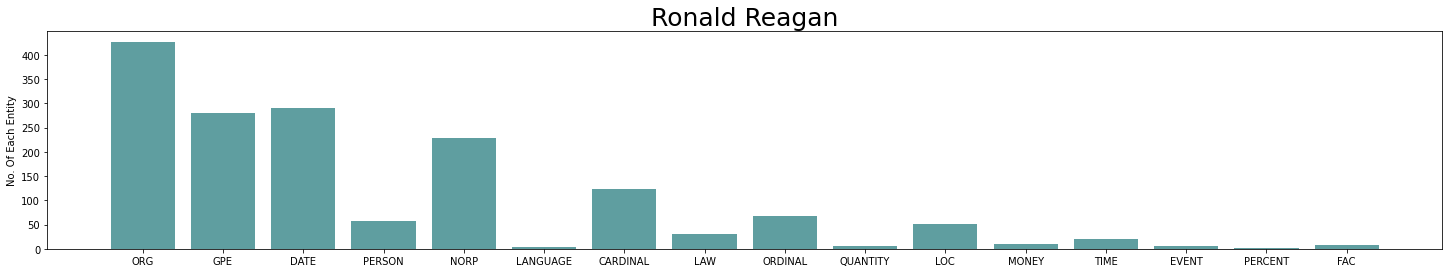

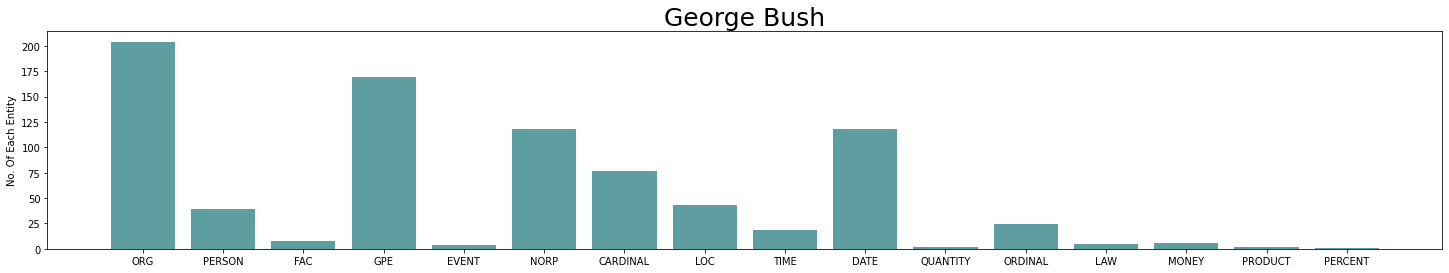

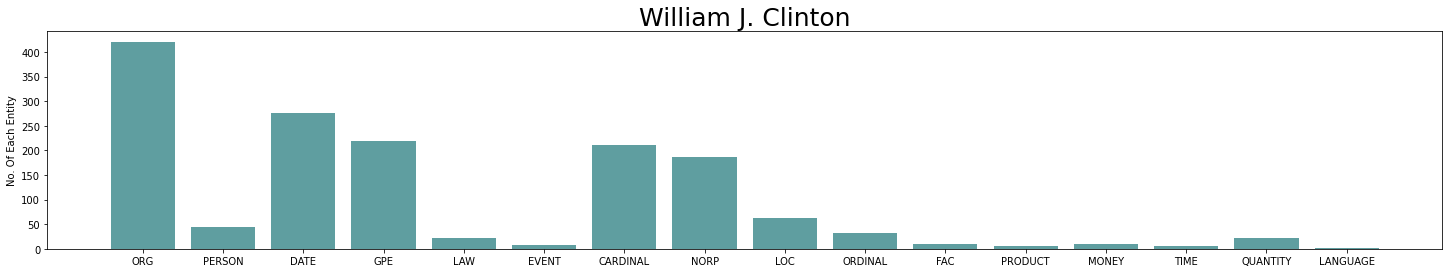

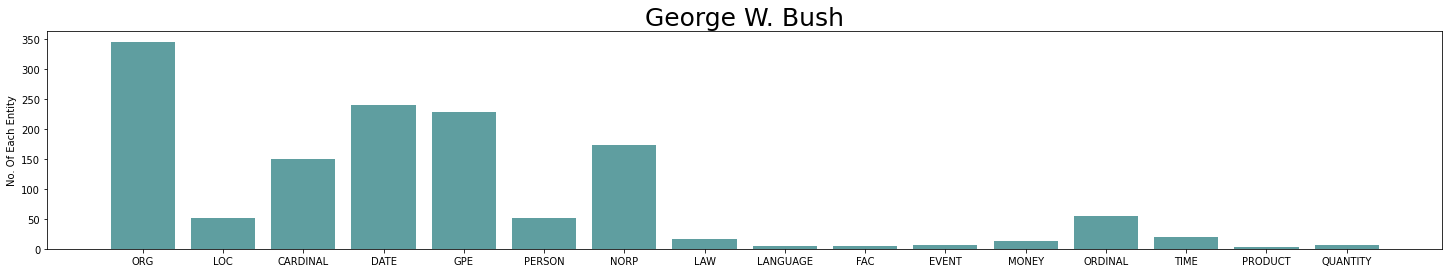

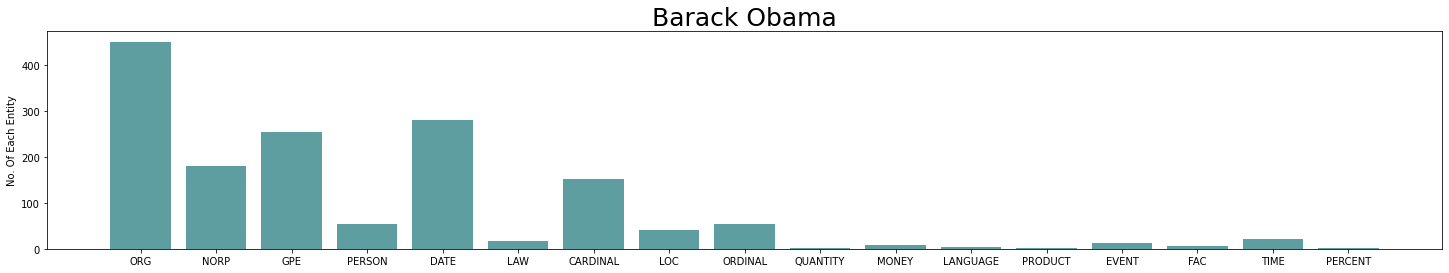

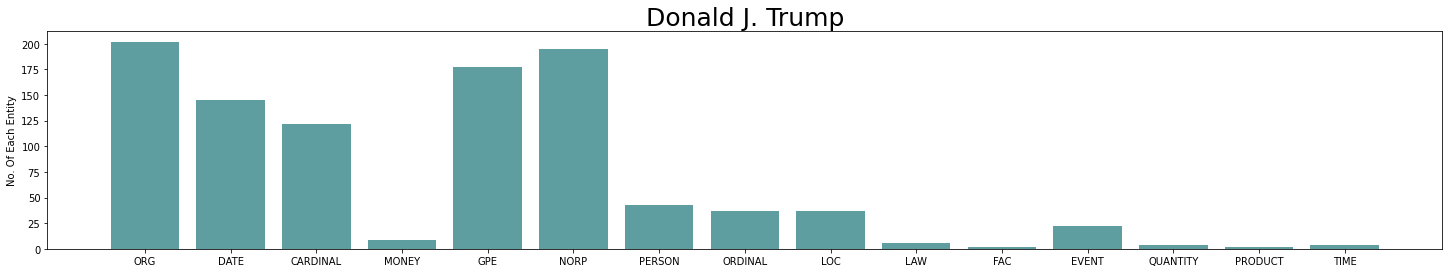

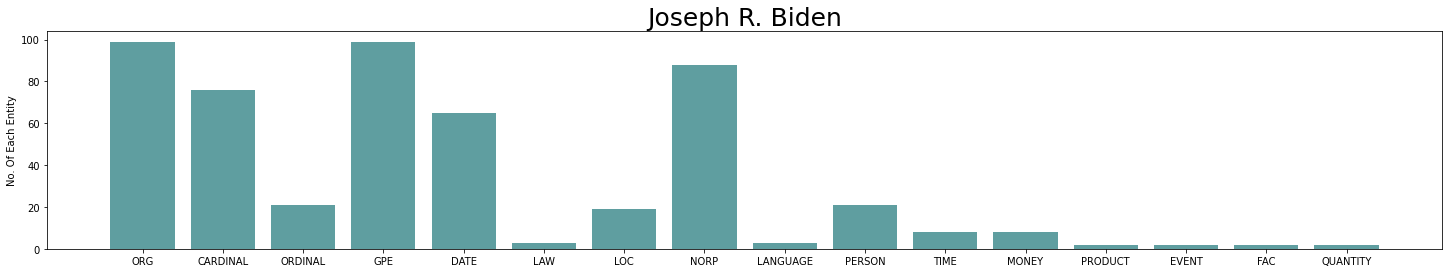

In [54]:
for president, clean_text in cleaned_text_dict.items():
  text , entity_counter = specify_NER(clean_text)
  create_bar_plot(entity_counter,president)
  print('\n')
  print('\n')


## Extract key phrases

In [55]:
# https://github.com/language-ml/course-nlp-ir-1-text-exploring/blob/main/notebooks/English/ExploreYourTextCollection-English.ipynb
def chunkTechnicalTerm(sentence):
    grammar = r"""
      TECHTERM: {<JJ|NN>+<NN|CD>|<NN>}
    """
    cp = RegexpParser(grammar)
    return (cp.parse(sentence))

In [56]:
def extract_key(dict_of_corpous, min_count):
    president_technical_terms = {}

    for president in dict_of_corpous.keys():
        president_technical_terms[president] = []
        sentences_tagged = []
        corpus_normlized = normalize_and_cleaning(dict_of_corpous[president], lemm=False, stop_word=False, remove_punct=False, remove_number=False)
        sentences = sent_tokenize(corpus_normlized)
        sentences = [normalize_and_cleaning(sen, lemm=False, stop_word=False) for sen in sentences]
        for sent in sentences:
            try:
                sentences_tagged.append(pos_tag(sent.split(' ')))
            except:
                pass
        for the_sentence in sentences_tagged:
            tree=chunkTechnicalTerm(the_sentence)
            for subtree in tree.subtrees():
                if subtree.label() == 'TECHTERM':
                    president_technical_terms[president].append(subtree.leaves())



    for president in president_technical_terms.keys():
        president_technical_terms[president]=FreqDist([' '.join([x for x,y in sent]) for sent in president_technical_terms[president] if len(sent)>1]).most_common(min_count)    


    president_technical_terms = pd.DataFrame(president_technical_terms) 
    return president_technical_terms

In [57]:
join_text_dict = {}
for president, text_list in president_text_dict.items():
  join_text_dict[president] = ' '.join(text_list)

In [58]:
MIN_COUNT = 40
freq_analysis_phrase2 = extract_key(join_text_dict, MIN_COUNT)
freq_analysis_phrase2

,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James K. Polk,...,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump,Joseph R. Biden
0,"(federal government, 27)","(national government, 11)","(past year, 13)","(fiscal year, 21)","(supreme court, 18)","(federal government, 24)","(national government, 24)","(last year, 18)","(public debt, 8)","(last year, 12)",...,"(general government, 27)","(federal government, 13)","(federal government, 15)","(last session, 15)","(soviet union, 7)","(federal government, 21)","(last year, 12)","(social security, 19)","(free world, 20)","(national government, 13)"
1,"(department state, 18)","(saddam hussein, 10)","(last year, 11)","(public debt, 18)","(district columbia, 13)","(first time, 10)","(fiscal year, 14)","(federal government, 10)","(great britain, 7)","(fiscal year, 9)",...,"(same time, 21)","(community development, 12)","(last year, 9)","(same time, 12)","(great britain, 6)","(fiscal year, 18)","(public money, 11)","(past year, 14)","(federal government, 14)","(last session, 4)"
2,"(national government, 14)","(last year, 6)","(attention congress, 11)","(past year, 13)","(federal government, 10)","(energy crisis, 8)","(last year, 14)","(new budget, 7)","(last session congress, 7)","(american rescue plan, 5)",...,"(federal government, 17)","(joint resolution, 6)","(fiscal year, 9)","(federal government, 12)","(public debt, 4)","(last session, 15)","(public debt, 9)","(french government, 13)","(public service, 11)","(district columbia, 4)"
3,"(last session, 12)","(monroe doctrine, 6)","(federal government, 10)","(last session, 12)","(same time, 10)","(same time, 7)","(federal government, 11)","(executive branch, 7)","(last session, 6)","(long time, 5)",...,"(last session, 17)","(past year, 6)","(social security, 9)","(great britain, 11)","(special attention, 4)","(last congress, 9)","(last session, 8)","(federal government, 11)","(soviet union, 11)","(supreme court, 4)"
4,"(department commerce, 12)","(public service, 6)","(same time, 9)","(great britain, 11)","(department state, 10)","(last year, 7)","(first time, 11)","(next year, 6)","(last year, 5)","(past year, 5)",...,"(great britain, 16)","(island cuba, 5)","(soviet union, 7)","(british government, 10)","(last fiscal year, 4)","(great britain, 9)","(same time, 8)","(great britain, 10)","(gold reserve, 7)","(long run, 4)"
5,"(supreme court, 11)","(such law, 5)","(public debt, 9)","(federal government, 11)","(great britain, 10)","(low income, 7)","(same time, 9)","(first time, 6)","(commercial intercourse, 4)","(white labor, 5)",...,"(fiscal year, 16)","(hard work freedom, 5)","(free world, 6)","(post-office department, 8)","(last year, 4)","(last year, 9)","(federal government, 8)","(last session, 9)","(past eight, 5)","(interstate commerce commission, 4)"
6,"(great britain, 10)","(fiscal year, 5)","(last session, 9)","(same time, 10)","(last session, 9)","(new federalism, 7)","(supreme court, 9)","(cold war, 5)","(french government, 4)","(first lady, 4)",...,"(past year, 14)","(regular army, 4)","(same time, 5)","(present condition, 7)","(public land, 4)","(same time, 8)","(great britain, 7)","(public service, 9)","(national debt, 5)","(provisional government, 4)"
7,"(executive branch, 9)","(business world, 4)","(mexican government, 9)","(present fiscal year, 9)","(cost living, 8)","(additional million, 6)","(last congress, 8)","(private sector, 5)","(present year, 4)","(federal government, 4)",...,"(secretary war, 14)","(san juan, 4)","(public debt, 5)","(next fiscal year, 7)","(slave trade, 3)","(last fiscal year, 8)","(past year, 7)","(same time, 9)","(other way, 4)","(other hand, 3)"
8,"(same time, 9)","(past year, 4)","(secretary war, 8)","(next fiscal year, 9)","(last year, 8)","(fiscal year, 6)","(department justice, 8)","(old way, 5)","(public service, 4)","(ge

In [59]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), #,"component_9","component_10","component_11","component_12"
             index = ["component_1","component_2","component_3","component_4","component_5","component_6","component_7","component_8"],
             columns = vectorizer.get_feature_names()) #8 components in final draft
topic_word

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandoned,abandonment,abate,abatement,abdicate,abdication,abet,abeyance,abhorrence,abide,...,zarqawi,zeal,zealand,zealous,zealously,zelaya,zero,zimbabwe,zinc,zone
component_1,0.009,0.018,0.007,0.008,0.000,0.000,0.003,0.016,0.003,0.005,...,0.000,0.032,0.008,0.010,0.009,0.006,0.004,0.000,0.002,0.016
component_2,0.004,0.002,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.007,...,0.000,0.000,0.000,0.000,0.000,0.000,0.022,0.000,0.000,0.031
component_3,0.000,0.002,0.000,0.007,0.000,0.003,0.005,0.000,0.000,0.015,...,0.000,0.054,0.000,0.032,0.006,0.000,0.000,0.000,0.000,0.000
component_4,0.001,0.002,0.003,0.007,0.000,0.005,0.000,0.000,0.000,0.000,...,0.000,0.001,0.003,0.000,0.000,0.000,0.006,0.006,0.000,0.009
component_5,0.000,0.011,0.005,0.000,0.007,0.002,0.000,0.002,0.000,0.012,...,0.000,0.002,0.004,0.003,0.002,0.016,0.000,0.000,0.003,0.026
component_6,0.000,0.000,0.001,0.000,0.003,0.005,0.000,0.000,0.000,0.013,...,0.000,0.003,0.014,0.000,0.000,0.000,0.000,0.000,0.005,0.000
component_7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.026,0.000,0.000,0.000,0.000,0.000,0.005,0.015,0.000,0.001
component_8,0.000,0.012,0.003,0.002,0.000,0.001,0.001,0.001,0.004,0.009,...,0.000,0.015,0.004,0.000,0.005,0.000,0.000,0.000,0.000,0.000


In [60]:
def nmf_display(nmf_model, tf_vectorizer_model,number_show):
    names = tf_vectorizer_model.get_feature_names()
    #number_show = 10
    for ind, topic in enumerate(nmf_model.components_):
        topic_list = [names[i] for i in np.argsort(topic * -1)[:number_show]]
        print(f"Topic {ind}: {topic_list}")
        

In [61]:
n_top_words = 10
feature_names = vectorizer.get_feature_names()
nmf_display(nmf_model, vectorizer, n_top_words)

Topic 0: ['silver', 'gold', 'cent', 'pension', 'circulation', 'currency', 'coinage', 'note', 'coin', 'postal']
Topic 1: ['tonight', 'job', 'thank', 'parent', 'challenge', 'percent', 'deficit', 'college', 'hard', 'kid']
Topic 2: ['spain', 'militia', 'tribe', 'navigation', 'gentleman', 'colony', 'french', 'legislature', 'neutral', 'ensue']
Topic 3: ['billion', 'major', 'goal', 'percent', 'inflation', 'nuclear', 'soviet', 'oil', 'housing', 'environmental']
Topic 4: ['corporation', 'interstate', 'tariff', 'conference', 'cent', 'railroad', 'philippine', 'canal', 'bureau', 'forest']
Topic 5: ['communist', 'soviet', 'objective', 'democratic', 'atomic', 'aggression', 'democracy', 'group', 'living', 'weapon']
Topic 6: ['iraq', 'terrorist', 'iraqi', 'terror', 'tonight', 'qaida', 'regime', 'afghanistan', 'saddam', 'weapon']
Topic 7: ['texas', 'mexican', 'slave', 'california', 'currency', 'paper', 'slavery', 'oregon', 'specie', 'note']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:

H = pd.DataFrame(doc_topic.round(5),   index= concat_president_year, #,"component_9","component_10"          
             columns = ["component_1","component_2", "component_3","component_4","component_5","component_6","component_7","component_8"])


In [63]:
H.head(20)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8
George Washington_1790,0.09603,0.00000,0.00865,0.00000,0.28086,0.00000,0.00000,0.00000
George Washington_1790,0.00000,0.00000,0.00000,0.01220,0.24050,0.03494,0.00000,0.02661
George Washington_1791,0.00000,0.00000,0.00813,0.10741,0.09330,0.28081,0.00000,0.00000
George Washington_1792,0.00000,0.00000,0.00620,0.00831,0.37958,0.01155,0.00000,0.00000
George Washington_1793,0.00000,0.00000,0.01849,0.02461,0.35937,0.00770,0.00000,0.00370
George Washington_1794,0.06439,0.00000,0.00000,0.00000,0.29464,0.00000,0.00000,0.03578
George Washington_1795,0.00000,0.00000,0.18397,0.00000,0.00000,0.03035,0.02286,0.00000
George Washington_1796,0.00000,0.00200,0.23378,0.00362,0.00000,0.00157,0.00247,0.00000
John Adams_1797,0.00344,0.01966,0.00000,0.00000,0.41561,0.00000,0.00350,0.04007
John Adams_1798,0.00000,0.00000,0.00000,0.00857,0.00000,0.02013,0.48867,0.00000


In [64]:
H.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8
George Washington_1790,0.09603,0.0,0.00865,0.00000,0.28086,0.00000,0.0,0.00000
George Washington_1790,0.00000,0.0,0.00000,0.01220,0.24050,0.03494,0.0,0.02661
George Washington_1791,0.00000,0.0,0.00813,0.10741,0.09330,0.28081,0.0,0.00000
George Washington_1792,0.00000,0.0,0.00620,0.00831,0.37958,0.01155,0.0,0.00000
George Washington_1793,0.00000,0.0,0.01849,0.02461,0.35937,0.00770,0.0,0.00370


In [65]:
H1 = H.reset_index(drop=True)

In [66]:
H1.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8
0,0.09603,0.0,0.00865,0.00000,0.28086,0.00000,0.0,0.00000
1,0.00000,0.0,0.00000,0.01220,0.24050,0.03494,0.0,0.02661
2,0.00000,0.0,0.00813,0.10741,0.09330,0.28081,0.0,0.00000
3,0.00000,0.0,0.00620,0.00831,0.37958,0.01155,0.0,0.00000
4,0.00000,0.0,0.01849,0.02461,0.35937,0.00770,0.0,0.00370


In [67]:
model = KMeans(n_clusters = 8)
model.fit(H1)
print (model.labels_)
H1['clust'] = pd.Series(model.labels_)
H1['Year'] = df['Year']
H1.head()

[4 4 2 4 4 4 0 0 4 7 1 5 2 6 1 5 0 5 3 1 5 2 5 1 1 3 1 2 6 0 0 1 4 2 4 5 6
 0 0 1 2 5 1 4 3 1 6 2 0 0 1 6 0 2 1 5 1 5 1 5 7 0 5 5 5 2 2 6 6 1 4 0 4 1
 5 3 2 3 6 2 0 3 4 3 0 4 4 1 3 0 4 7 2 2 5 2 5 1 3 3 6 0 3 6 0 7 0 0 4 3 6
 0 2 1 4 4 7 2 0 3 0 0 0 1 0 2 6 0 5 3 4 1 6 0 3 3 5 7 6 2 4 3 0 0 2 0 3 5
 3 3 5 2 0 2 6 5 0 4 6 6 6 4 1 3 0 0 3 3 3 2 1 6 5 2 6 0 0 5 6 3 0 5 2 3 4
 5 3 4 2 3 0 1 5 0 3 2 6 2 5 4 2 7 6 6 5 2 2 1 2 5 0 3 3 1 3 0 4 0 4 0 4 0
 2 1 5 2 3 2 0 5 4 4 5 2 1 3 2 5 4]


,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,clust,Year
0,0.09603,0.0,0.00865,0.00000,0.28086,0.00000,0.0,0.00000,4,1790
1,0.00000,0.0,0.00000,0.01220,0.24050,0.03494,0.0,0.02661,4,1790
2,0.00000,0.0,0.00813,0.10741,0.09330,0.28081,0.0,0.00000,2,1791
3,0.00000,0.0,0.00620,0.00831,0.37958,0.01155,0.0,0.00000,4,1792
4,0.00000,0.0,0.01849,0.02461,0.35937,0.00770,0.0,0.00370,4,1793


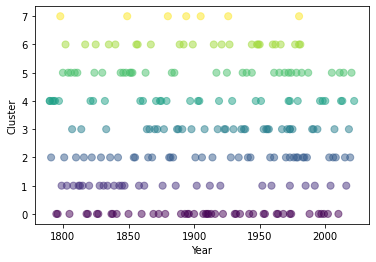

In [68]:
plt.scatter(H1['Year'], H1['clust'], c= model.labels_.astype(float), s=50, alpha=0.5)

plt.xlabel("Year") 
plt.ylabel("Cluster")
plt.show()

In [69]:
H.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8
George Washington_1790,0.09603,0.0,0.00865,0.00000,0.28086,0.00000,0.0,0.00000
George Washington_1790,0.00000,0.0,0.00000,0.01220,0.24050,0.03494,0.0,0.02661
George Washington_1791,0.00000,0.0,0.00813,0.10741,0.09330,0.28081,0.0,0.00000
George Washington_1792,0.00000,0.0,0.00620,0.00831,0.37958,0.01155,0.0,0.00000
George Washington_1793,0.00000,0.0,0.01849,0.02461,0.35937,0.00770,0.0,0.00370
